In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale
import copy
import seaborn as sns
import heapq
import scipy.stats as stats
from dtw import *
import dtw
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import seaborn as sns
import copy
import scipy.stats as stats
from IPython.display import Image, display
from collections import Counter, OrderedDict
from itertools import chain
import torch
import torch.nn as nn
from torchmetrics.functional import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# imports for training
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss
plt.style.use('seaborn-v0_8-darkgrid')

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_2022 = pd.read_csv('2022_country_daily_2022_US_daily_symptoms_dataset.csv')
df_2021 = pd.read_csv('2021_country_daily_2021_US_daily_symptoms_dataset.csv')
df_2020 = pd.read_csv('2020_country_daily_2020_US_daily_symptoms_dataset.csv')
df = pd.concat([df_2020, df_2021, df_2022], ignore_index=True)
df.sub_region_1.replace(np.nan, "national", inplace=True)
df

country_region_code country_region sub_region_1 sub_region_1_code  \
0                      US  United States     national               NaN   
1                      US  United States     national               NaN   
2                      US  United States     national               NaN   
3                      US  United States     national               NaN   
4                      US  United States     national               NaN   
...                   ...            ...          ...               ...   
53035                  US  United States      Wyoming             US-WY   
53036                  US  United States      Wyoming             US-WY   
53037                  US  United States      Wyoming             US-WY   
53038                  US  United States      Wyoming             US-WY   
53039                  US  United States      Wyoming             US-WY   

       sub_region_2  sub_region_2_code                     place_id  \
0               NaN                NaN  ChIJCzYy5IS16lQRQrfeQ5K5Oxw   
1               NaN                NaN  ChIJCzYy5IS16lQRQrfeQ5K5Oxw   
2               NaN                NaN  ChIJCzYy5IS16lQRQrfeQ5K5Oxw   
3               NaN                NaN  ChIJCzYy5IS16lQRQrfeQ5K5Oxw   
4               NaN                NaN  ChIJCzYy5IS16lQRQrfeQ5K5Oxw   
...             ...                ...                          ...   
53035           NaN                NaN  ChIJaS7hSDTiXocRLzh90nkisCY   
53036           NaN                NaN  ChIJaS7hSDTiXocRLzh90nkisCY   
53037           NaN                NaN  ChIJaS7hSDTiXocRLzh90nkisCY   
53038           NaN                NaN  ChIJaS7hSDTiXocRLzh90nkisCY   
53039           NaN                NaN  ChIJaS7hSDTiXocRLzh90nkisCY   

             date  symptom:Abdominal obesity  symptom:Abdominal pain  ...  \
0      2020-01-01                       2.42                    4.71  ...   
1      2020-01-02                       2.40                    4.66  ...   
2      2020-01-03                       2.13                    4.54  ...   
3      2020-01-04                       2.30                    4.60  ...   
4      2020-01-05                       2.53                    4.59  ...   
...           ...                        ...                     ...  ...   
53035  2022-10-12                       1.56                    4.32  ...   
53036  2022-10-13                       0.99                    4.03  ...   
53037  2022-10-14                       1.14                    4.12  ...   
53038  2022-10-15                       1.20                    4.06  ...   
53039  2022-10-16                       1.73                    4.28  ...   

       symptom:Wart  symptom:Water retention  symptom:Weakness  \
0              1.23                     0.23              0.32   
1              1.33                     0.25              0.37   
2              1.29                     0.24              0.36   
3              1.24                     0.24              0.34   
4              1.25                     0.24              0.34   
...             ...                      ...               ...   
53035          0.96                      NaN              0.69   
53036          1.17                      NaN              0.89   
53037          1.16                      NaN               NaN   
53038          1.55                      NaN               NaN   
53039          1.33                      NaN               NaN   

       symptom:Weight gain  symptom:Wheeze  symptom:Xeroderma  \
0                     3.13            0.34               2.65   
1                     3.36            0.33               2.60   
2                     3.17            0.32               2.46   
3                     3.15            0.31               2.71   
4                     3.38            0.31               2.81   
...                    ...             ...                ...   
53035                 2.63             NaN               1.51   
53036         

In [3]:
symptoms = ["symptom:Abdominal obesity","symptom:Abdominal pain","symptom:Acne","symptom:Actinic keratosis","symptom:Acute bronchitis","symptom:Adrenal crisis","symptom:Ageusia","symptom:Alcoholism","symptom:Allergic conjunctivitis","symptom:Allergy","symptom:Amblyopia","symptom:Amenorrhea","symptom:Amnesia","symptom:Anal fissure","symptom:Anaphylaxis","symptom:Anemia","symptom:Angina pectoris","symptom:Angioedema","symptom:Angular cheilitis","symptom:Anosmia","symptom:Anxiety","symptom:Aphasia","symptom:Aphonia","symptom:Apnea","symptom:Arthralgia","symptom:Arthritis","symptom:Ascites","symptom:Asperger syndrome","symptom:Asphyxia","symptom:Asthma","symptom:Astigmatism","symptom:Ataxia","symptom:Atheroma","symptom:Attention deficit hyperactivity disorder","symptom:Auditory hallucination","symptom:Autoimmune disease","symptom:Avoidant personality disorder","symptom:Back pain","symptom:Bacterial vaginosis","symptom:Balance disorder","symptom:Beau's lines","symptom:Bell's palsy","symptom:Biliary colic","symptom:Binge eating","symptom:Bleeding","symptom:Bleeding on probing","symptom:Blepharospasm","symptom:Bloating","symptom:Blood in stool","symptom:Blurred vision","symptom:Blushing","symptom:Boil","symptom:Bone fracture","symptom:Bone tumor","symptom:Bowel obstruction","symptom:Bradycardia","symptom:Braxton Hicks contractions","symptom:Breakthrough bleeding","symptom:Breast pain","symptom:Bronchitis","symptom:Bruise","symptom:Bruxism","symptom:Bunion","symptom:Burn","symptom:Burning Chest Pain","symptom:Burning mouth syndrome","symptom:Candidiasis","symptom:Canker sore","symptom:Cardiac arrest","symptom:Carpal tunnel syndrome","symptom:Cataplexy","symptom:Cataract","symptom:Chancre","symptom:Cheilitis","symptom:Chest pain","symptom:Chills","symptom:Chorea","symptom:Chronic pain","symptom:Cirrhosis","symptom:Cleft lip and cleft palate","symptom:Clouding of consciousness","symptom:Cluster headache","symptom:Colitis","symptom:Coma","symptom:Common cold","symptom:Compulsive behavior","symptom:Compulsive hoarding","symptom:Confusion","symptom:Congenital heart defect","symptom:Conjunctivitis","symptom:Constipation","symptom:Convulsion","symptom:Cough","symptom:Crackles","symptom:Cramp","symptom:Crepitus","symptom:Croup","symptom:Cyanosis","symptom:Dandruff","symptom:Delayed onset muscle soreness","symptom:Dementia","symptom:Dentin hypersensitivity","symptom:Depersonalization","symptom:Depression","symptom:Dermatitis","symptom:Desquamation","symptom:Developmental disability","symptom:Diabetes","symptom:Diabetic ketoacidosis","symptom:Diarrhea","symptom:Dizziness","symptom:Dry eye syndrome","symptom:Dysautonomia","symptom:Dysgeusia","symptom:Dysmenorrhea","symptom:Dyspareunia","symptom:Dysphagia","symptom:Dysphoria","symptom:Dystonia","symptom:Dysuria","symptom:Ear pain","symptom:Eczema","symptom:Edema","symptom:Encephalitis","symptom:Encephalopathy","symptom:Epidermoid cyst","symptom:Epilepsy","symptom:Epiphora","symptom:Erectile dysfunction","symptom:Erythema","symptom:Erythema chronicum migrans","symptom:Esophagitis","symptom:Excessive daytime sleepiness","symptom:Eye pain","symptom:Eye strain","symptom:Facial nerve paralysis","symptom:Facial swelling","symptom:Fasciculation","symptom:Fatigue","symptom:Fatty liver disease","symptom:Fecal incontinence","symptom:Fever","symptom:Fibrillation","symptom:Fibrocystic breast changes","symptom:Fibromyalgia","symptom:Flatulence","symptom:Floater","symptom:Focal seizure","symptom:Folate deficiency","symptom:Food craving","symptom:Food intolerance","symptom:Frequent urination","symptom:Gastroesophageal reflux disease","symptom:Gastroparesis","symptom:Generalized anxiety disorder","symptom:Generalized tonic–clonic seizure","symptom:Genital wart","symptom:Gingival recession","symptom:Gingivitis","symptom:Globus pharyngis","symptom:Goitre","symptom:Gout","symptom:Grandiosity","symptom:Granuloma","symptom:Guilt","symptom:Hair loss","symptom:Halitosis","symptom:Hay fever","symptom:Headache","symptom:Heart arrhythmia","symptom:Heart murmur","symptom:Heartburn","symptom:Hematochezia","symptom:Hematoma","symptom:Hematuria","symptom:Hemolysis","symptom:Hemoptysis","symptom:Hemorrhoids","symptom:Hepatic encephalopathy","symptom:Hepatitis","symptom:Hepatotoxicity","symptom:Hiccup","symptom:Hip pain","symptom:Hives","symptom:Hot flash","symptom:Hydrocephalus","symptom:Hypercalcaemia","symptom:Hypercapnia","symptom:Hypercholesterolemia","symptom:Hyperemesis gravidarum","symptom:Hyperglycemia","symptom:Hyperkalemia","symptom:Hyperlipidemia","symptom:Hypermobility","symptom:Hyperpigmentation","symptom:Hypersomnia","symptom:Hypertension","symptom:Hyperthermia","symptom:Hyperthyroidism","symptom:Hypertriglyceridemia","symptom:Hypertrophy","symptom:Hyperventilation","symptom:Hypocalcaemia","symptom:Hypochondriasis","symptom:Hypoglycemia","symptom:Hypogonadism","symptom:Hypokalemia","symptom:Hypomania","symptom:Hyponatremia","symptom:Hypotension","symptom:Hypothyroidism","symptom:Hypoxemia","symptom:Hypoxia","symptom:Impetigo","symptom:Implantation bleeding","symptom:Impulsivity","symptom:Indigestion","symptom:Infection","symptom:Inflammation","symptom:Inflammatory bowel disease","symptom:Ingrown hair","symptom:Insomnia","symptom:Insulin resistance","symptom:Intermenstrual bleeding","symptom:Intracranial pressure","symptom:Iron deficiency","symptom:Irregular menstruation","symptom:Itch","symptom:Jaundice","symptom:Kidney failure","symptom:Kidney stone","symptom:Knee Pain","symptom:Kyphosis","symptom:Lactose intolerance","symptom:Laryngitis","symptom:Leg cramps","symptom:Lesion","symptom:Leukorrhea","symptom:Lightheadedness","symptom:Low back pain","symptom:Low-grade fever","symptom:Lymphedema","symptom:Major depressive disorder","symptom:Malabsorption","symptom:Male infertility","symptom:Manic Disorder","symptom:Melasma","symptom:Melena","symptom:Meningitis","symptom:Menorrhagia","symptom:Middle back pain","symptom:Migraine","symptom:Milium","symptom:Mitral insufficiency","symptom:Mood disorder","symptom:Mood swing","symptom:Morning sickness","symptom:Motion sickness","symptom:Mouth ulcer","symptom:Muscle atrophy","symptom:Muscle weakness","symptom:Myalgia","symptom:Mydriasis","symptom:Myocardial infarction","symptom:Myoclonus","symptom:Nasal congestion","symptom:Nasal polyp","symptom:Nausea","symptom:Neck mass","symptom:Neck pain","symptom:Neonatal jaundice","symptom:Nerve injury","symptom:Neuralgia","symptom:Neutropenia","symptom:Night sweats","symptom:Night terror","symptom:Nocturnal enuresis","symptom:Nodule","symptom:Nosebleed","symptom:Nystagmus","symptom:Obesity","symptom:Onychorrhexis","symptom:Oral candidiasis","symptom:Orthostatic hypotension","symptom:Osteopenia","symptom:Osteophyte","symptom:Osteoporosis","symptom:Otitis","symptom:Otitis externa","symptom:Otitis media","symptom:Pain","symptom:Palpitations","symptom:Panic attack","symptom:Papule","symptom:Paranoia","symptom:Paresthesia","symptom:Pelvic inflammatory disease","symptom:Pericarditis","symptom:Periodontal disease","symptom:Periorbital puffiness","symptom:Peripheral neuropathy","symptom:Perspiration","symptom:Petechia","symptom:Phlegm","symptom:Photodermatitis","symptom:Photophobia","symptom:Photopsia","symptom:Pleural effusion","symptom:Pleurisy","symptom:Pneumonia","symptom:Podalgia","symptom:Polycythemia","symptom:Polydipsia","symptom:Polyneuropathy","symptom:Polyuria","symptom:Poor posture","symptom:Post-nasal drip","symptom:Postural orthostatic tachycardia syndrome","symptom:Prediabetes","symptom:Proteinuria","symptom:Pruritus ani","symptom:Psychosis","symptom:Ptosis","symptom:Pulmonary edema","symptom:Pulmonary hypertension","symptom:Purpura","symptom:Pus","symptom:Pyelonephritis","symptom:Radiculopathy","symptom:Rectal pain","symptom:Rectal prolapse","symptom:Red eye","symptom:Renal colic","symptom:Restless legs syndrome","symptom:Rheum","symptom:Rhinitis","symptom:Rhinorrhea","symptom:Rosacea","symptom:Round ligament pain","symptom:Rumination","symptom:Scar","symptom:Sciatica","symptom:Scoliosis","symptom:Seborrheic dermatitis","symptom:Self-harm","symptom:Sensitivity to sound","symptom:Sexual dysfunction","symptom:Shallow breathing","symptom:Sharp pain","symptom:Shivering","symptom:Shortness of breath","symptom:Shyness","symptom:Sinusitis","symptom:Skin condition","symptom:Skin rash","symptom:Skin tag","symptom:Skin ulcer","symptom:Sleep apnea","symptom:Sleep deprivation","symptom:Sleep disorder","symptom:Snoring","symptom:Sore throat","symptom:Spasticity","symptom:Splenomegaly","symptom:Sputum","symptom:Stomach rumble","symptom:Strabismus","symptom:Stretch marks","symptom:Stridor","symptom:Stroke","symptom:Stuttering","symptom:Subdural hematoma","symptom:Suicidal ideation","symptom:Swelling","symptom:Swollen feet","symptom:Swollen lymph nodes","symptom:Syncope","symptom:Tachycardia","symptom:Tachypnea","symptom:Telangiectasia","symptom:Tenderness","symptom:Testicular pain","symptom:Throat irritation","symptom:Thrombocytopenia","symptom:Thyroid nodule","symptom:Tic","symptom:Tinnitus","symptom:Tonsillitis","symptom:Toothache","symptom:Tremor","symptom:Trichoptilosis","symptom:Tumor","symptom:Type 2 diabetes","symptom:Unconsciousness","symptom:Underweight","symptom:Upper respiratory tract infection","symptom:Urethritis","symptom:Urinary incontinence","symptom:Urinary tract infection","symptom:Urinary urgency","symptom:Uterine contraction","symptom:Vaginal bleeding","symptom:Vaginal discharge","symptom:Vaginitis","symptom:Varicose veins","symptom:Vasculitis","symptom:Ventricular fibrillation","symptom:Ventricular tachycardia","symptom:Vertigo","symptom:Viral pneumonia","symptom:Visual acuity","symptom:Vomiting","symptom:Wart","symptom:Water retention","symptom:Weakness","symptom:Weight gain","symptom:Wheeze","symptom:Xeroderma","symptom:Xerostomia","symptom:Yawn","symptom:hyperhidrosis","symptom:pancreatitis"]
meta_column = ["country_region_code","country_region","sub_region_1","sub_region_1_code","sub_region_2","sub_region_2_code","place_id","date"]
state_to_symbol = {'national': 'national', 'California': 'CA', 'New York': 'NY', 'Georgia': 'GA', 'Texas': 'TX', 'Alaska': 'AK', "Mississippi": 'MS', 'Alabama': 'AL', 'South Carolina': 'SC'}
top_k_symptoms = ["symptom:Ageusia", "symptom:Hypoxemia" , "symptom:Low-grade fever", "symptom:Dysgeusia", "symptom:Fever", "symptom:Anosmia", "symptom:Chills", "symptom:Pneumonia", "symptom:Shallow breathing", "symptom:Eye pain", "symptom:Shortness of breath", "symptom:Headache", "symptom:Shivering", "symptom:Migraine", "symptom:Hyperthermia"]

In [4]:
covid_data = pd.read_csv('Weekly_United_States_COVID-19_Cases_and_Deaths_by_State.csv')
for n, week in copy.copy(covid_data.groupby('date_updated')):
    week = week.reset_index(drop=True)
    tempdf = pd.DataFrame([[week.date_updated.loc[0], 'national', week.start_date.loc[0], week.end_date.loc[0], week.tot_cases.sum(), week.new_cases.sum(), week.tot_deaths.sum(), week.new_deaths.sum()]], columns = covid_data.columns)
    covid_data = pd.concat([covid_data, tempdf], ignore_index= True)

In [5]:

region = 'national'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = (covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True))
covid_data = covid_data.loc[covid_data.state == state_to_symbol["national"]]['new_cases']
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
dates = tempdf['date']
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
national_trend_data = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)[top_k_symptoms]

In [6]:
dates[[120, 124, 128]]

120   2022-05-15
124   2022-06-12
128   2022-07-10
Name: date, dtype: datetime64[ns]

In [7]:
dates[[132, 133, 134]]

132   2022-08-07
133   2022-08-14
134   2022-08-21
Name: date, dtype: datetime64[ns]

In [8]:
covid_normalized = (covid_data / covid_data.max())
ageusia_normalized = (national_trend_data["symptom:Ageusia"].interpolate()/national_trend_data["symptom:Ageusia"].interpolate().max())
hypoxemia_normalized = (national_trend_data["symptom:Hypoxemia"].interpolate()/national_trend_data["symptom:Hypoxemia"].interpolate().max())
lgfever_normalized = (national_trend_data["symptom:Low-grade fever"].interpolate()/national_trend_data["symptom:Low-grade fever"].interpolate().max())

In [9]:
final_df = pd.DataFrame(data=zip(covid_normalized, ageusia_normalized, hypoxemia_normalized, lgfever_normalized,  range(len(covid_normalized))) , columns=['cases', 'ageusia', 'hypoxemia', 'lgfever', 'dates'])

In [10]:
final_df

cases   ageusia  hypoxemia   lgfever  dates
0    0.000001  0.089681   0.250821  0.306080      0
1    0.000002  0.088911   0.273534  0.352566      1
2    0.000002  0.093843   0.284941  0.350774      2
3    0.000003  0.095610   0.284338  0.331849      3
4    0.000006  0.100058   0.280919  0.311270      4
..        ...       ...        ...       ...    ...
137  0.084465  0.136912   0.418560  0.248699    137
138  0.070759  0.142184   0.430876  0.249851    138
139  0.061281  0.131709   0.415083  0.249246    139
140  0.057268  0.128337   0.413334  0.242101    140
141  0.047312  0.139232   0.404677  0.240916    141

[142 rows x 5 columns]

# DeepAR

In [14]:
def train_model(dat, num, region="national"):
    # create dataset and dataloaders
    max_encoder_length = 30
    max_prediction_length = 20
    final_df = dat
    data = final_df
    data['series'] = [0 for x in range(len(final_df.dates.to_numpy()))]
    data = data.astype(dict(series=str))
    training_cutoff = data["dates"].max() - max_prediction_length

    context_length = max_encoder_length
    prediction_length = max_prediction_length

    training = TimeSeriesDataSet(
        data[lambda x: x.dates <= 140],
        time_idx="dates",
        target="cases",
        group_ids=["series"],
        static_categoricals=[
            "series"
            
        ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
        categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
        time_varying_unknown_reals=["cases"],
        time_varying_known_reals=["ageusia", "hypoxemia", "lgfever"],
        max_encoder_length=context_length,
        max_prediction_length=prediction_length,
        min_prediction_idx = 80,
        predict_mode=False
    )

    validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
    batch_size = 128
    # synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
    train_dataloader = training.to_dataloader(
        train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
    )
    val_dataloader = validation.to_dataloader(
        train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
    )
    pl.seed_everything(42)
    trainer = pl.Trainer(gpus=1, gradient_clip_val=1e-1)
    net = DeepAR.from_dataset(
        training, learning_rate=3e-2, hidden_size=30, rnn_layers=3, loss=MultivariateNormalDistributionLoss(rank=30)
    )
    net.hparams.learning_rate = 0.001
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    trainer = pl.Trainer(
        max_epochs=30,
        gpus=0,
        enable_model_summary=True,
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback],
        limit_train_batches=50,
        enable_checkpointing=True,
    )


    net = DeepAR.from_dataset(
        training,
        learning_rate=0.1,
        log_interval=10,
        log_val_interval=1,
        hidden_size=30,
        rnn_layers=2,
        loss=MultivariateNormalDistributionLoss(rank=30),
    )

    trainer.fit(
        net,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = DeepAR.load_from_checkpoint(best_model_path)
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)
    (actuals - predictions).abs().mean()
    raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)
    series = validation.x_to_index(x)["series"]
    for idx in range(1):  # plot 10 examples
        best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plt.savefig(f"{region}/Window_{region}_{n}.png")

        cases   ageusia  hypoxemia   lgfever  dates
0    0.000001  0.089681   0.250821  0.306080      0
1    0.000002  0.088911   0.273534  0.352566      1
2    0.000002  0.093843   0.284941  0.350774      2
3    0.000003  0.095610   0.284338  0.331849      3
4    0.000006  0.100058   0.280919  0.311270      4
..        ...       ...        ...       ...    ...
115  0.040570  0.144055   0.390146  0.234139    115
116  0.052249  0.163144   0.421686  0.247631    116
117  0.065788  0.159294   0.401594  0.243648    117
118  0.080615  0.166905   0.402239  0.254640    118
119  0.105368  0.174267   0.420268  0.285684    119

[120 rows x 5 columns]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 14: 100%|██████████| 22/22 [00:00<00:00, 29.43it/s, loss=-2.09, v_num=34, train_loss_step=-1.14, val_loss=-.590, train_loss_epoch=-2.11] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
1    0.000002  0.088911   0.273534  0.352566      1
2    0.000002  0.093843   0.284941  0.350774      2
3    0.000003  0.095610   0.284338  0.331849      3
4    0.000006  0.100058   0.280919  0.311270      4
5    0.000021  0.091614   0.281983  0.304004      5
..        ...       ...        ...       ...    ...
116  0.052249  0.163144   0.421686  0.247631    116
117  0.065788  0.159294   0.401594  0.243648    117
118  0.080615  0.166905   0.402239  0.254640    118
119  0.105368  0.174267   0.420268  0.285684    119
120  0.124707  0.180228   0.423204  0.309337    120

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (22) is smaller than t

Epoch 23: 100%|██████████| 23/23 [00:00<00:00, 28.73it/s, loss=-2.29, v_num=35, train_loss_step=-2.50, val_loss=-1.97, train_loss_epoch=-2.28]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
2    0.000002  0.093843   0.284941  0.350774      2
3    0.000003  0.095610   0.284338  0.331849      3
4    0.000006  0.100058   0.280919  0.311270      4
5    0.000021  0.091614   0.281983  0.304004      5
6    0.000221  0.090965   0.287551  0.355627      6
..        ...       ...        ...       ...    ...
117  0.065788  0.159294   0.401594  0.243648    117
118  0.080615  0.166905   0.402239  0.254640    118
119  0.105368  0.174267   0.420268  0.285684    119
120  0.124707  0.180228   0.423204  0.309337    120
121  0.138250  0.190654   0.426579  0.306544    121

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (23) is smaller than t

Epoch 14: 100%|██████████| 24/24 [00:00<00:00, 30.88it/s, loss=-2.05, v_num=36, train_loss_step=-.707, val_loss=0.417, train_loss_epoch=-2.07] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
3    0.000003  0.095610   0.284338  0.331849      3
4    0.000006  0.100058   0.280919  0.311270      4
5    0.000021  0.091614   0.281983  0.304004      5
6    0.000221  0.090965   0.287551  0.355627      6
7    0.001519  0.091055   0.292925  0.647926      7
..        ...       ...        ...       ...    ...
118  0.080615  0.166905   0.402239  0.254640    118
119  0.105368  0.174267   0.420268  0.285684    119
120  0.124707  0.180228   0.423204  0.309337    120
121  0.138250  0.190654   0.426579  0.306544    121
122  0.128173  0.193942   0.427678  0.309918    122

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (24) is smaller than t

Epoch 29: 100%|██████████| 25/25 [00:00<00:00, 31.55it/s, loss=-2.35, v_num=37, train_loss_step=-2.45, val_loss=-2.68, train_loss_epoch=-2.35] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 25/25 [00:00<00:00, 30.53it/s, loss=-2.35, v_num=37, train_loss_step=-2.45, val_loss=-2.68, train_loss_epoch=-2.35]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
4    0.000006  0.100058   0.280919  0.311270      4
5    0.000021  0.091614   0.281983  0.304004      5
6    0.000221  0.090965   0.287551  0.355627      6
7    0.001519  0.091055   0.292925  0.647926      7
8    0.010870  0.295373   0.370470  1.000000      8
..        ...       ...        ...       ...    ...
119  0.105368  0.174267   0.420268  0.285684    119
120  0.124707  0.180228   0.423204  0.309337    120
121  0.138250  0.190654   0.426579  0.306544    121
122  0.128173  0.193942   0.427678  0.309918    122
123  0.138200  0.189851   0.422741  0.297763    123

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (25) is smaller than t

Epoch 29: 100%|██████████| 26/26 [00:00<00:00, 33.71it/s, loss=-2.48, v_num=38, train_loss_step=-1.72, val_loss=-1.36, train_loss_epoch=-2.45]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 26/26 [00:00<00:00, 32.56it/s, loss=-2.48, v_num=38, train_loss_step=-1.72, val_loss=-1.36, train_loss_epoch=-2.45]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


        cases   ageusia  hypoxemia   lgfever  dates
5    0.000021  0.091614   0.281983  0.304004      5
6    0.000221  0.090965   0.287551  0.355627      6
7    0.001519  0.091055   0.292925  0.647926      7
8    0.010870  0.295373   0.370470  1.000000      8
9    0.028579  0.754219   0.518415  0.903235      9
..        ...       ...        ...       ...    ...
120  0.124707  0.180228   0.423204  0.309337    120
121  0.138250  0.190654   0.426579  0.306544    121
122  0.128173  0.193942   0.427678  0.309918    122
123  0.138200  0.189851   0.422741  0.297763    123
124  0.129947  0.175109   0.411182  0.267763    124

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: Fal

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (26) is smaller than t

Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 31.27it/s, loss=-2.61, v_num=39, train_loss_step=-2.82, val_loss=-2.53, train_loss_epoch=-2.50]   

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 30.23it/s, loss=-2.61, v_num=39, train_loss_step=-2.82, val_loss=-2.53, train_loss_epoch=-2.50]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
6    0.000221  0.090965   0.287551  0.355627      6
7    0.001519  0.091055   0.292925  0.647926      7
8    0.010870  0.295373   0.370470  1.000000      8
9    0.028579  0.754219   0.518415  0.903235      9
10   0.039310  0.494704   0.691871  0.721824     10
..        ...       ...        ...       ...    ...
121  0.138250  0.190654   0.426579  0.306544    121
122  0.128173  0.193942   0.427678  0.309918    122
123  0.138200  0.189851   0.422741  0.297763    123
124  0.129947  0.175109   0.411182  0.267763    124
125  0.124249  0.179977   0.406281  0.271463    125

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (27) is smaller than t

Epoch 29: 100%|██████████| 28/28 [00:00<00:00, 33.98it/s, loss=-2.46, v_num=40, train_loss_step=-2.67, val_loss=-2.28, train_loss_epoch=-2.40] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 28/28 [00:00<00:00, 32.86it/s, loss=-2.46, v_num=40, train_loss_step=-2.67, val_loss=-2.28, train_loss_epoch=-2.40]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
7    0.001519  0.091055   0.292925  0.647926      7
8    0.010870  0.295373   0.370470  1.000000      8
9    0.028579  0.754219   0.518415  0.903235      9
10   0.039310  0.494704   0.691871  0.721824     10
11   0.037118  0.362777   0.638060  0.575218     11
..        ...       ...        ...       ...    ...
122  0.128173  0.193942   0.427678  0.309918    122
123  0.138200  0.189851   0.422741  0.297763    123
124  0.129947  0.175109   0.411182  0.267763    124
125  0.124249  0.179977   0.406281  0.271463    125
126  0.138224  0.178706   0.423684  0.276982    126

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (28) is smaller than t

Epoch 29: 100%|██████████| 29/29 [00:00<00:00, 33.40it/s, loss=-2.31, v_num=41, train_loss_step=-2.18, val_loss=-2.91, train_loss_epoch=-2.31]   

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 29/29 [00:00<00:00, 32.33it/s, loss=-2.31, v_num=41, train_loss_step=-2.18, val_loss=-2.91, train_loss_epoch=-2.31]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
8    0.010870  0.295373   0.370470  1.000000      8
9    0.028579  0.754219   0.518415  0.903235      9
10   0.039310  0.494704   0.691871  0.721824     10
11   0.037118  0.362777   0.638060  0.575218     11
12   0.036183  0.318772   0.567602  0.444671     12
..        ...       ...        ...       ...    ...
123  0.138200  0.189851   0.422741  0.297763    123
124  0.129947  0.175109   0.411182  0.267763    124
125  0.124249  0.179977   0.406281  0.271463    125
126  0.138224  0.178706   0.423684  0.276982    126
127  0.139647  0.184430   0.421912  0.275823    127

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (29) is smaller than t

Epoch 25: 100%|██████████| 30/30 [00:00<00:00, 33.63it/s, loss=-2.39, v_num=42, train_loss_step=-2.73, val_loss=-2.41, train_loss_epoch=-2.26] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
9    0.028579  0.754219   0.518415  0.903235      9
10   0.039310  0.494704   0.691871  0.721824     10
11   0.037118  0.362777   0.638060  0.575218     11
12   0.036183  0.318772   0.567602  0.444671     12
13   0.034903  0.269113   0.676023  0.374784     13
..        ...       ...        ...       ...    ...
124  0.129947  0.175109   0.411182  0.267763    124
125  0.124249  0.179977   0.406281  0.271463    125
126  0.138224  0.178706   0.423684  0.276982    126
127  0.139647  0.184430   0.421912  0.275823    127
128  0.155027  0.192414   0.447637  0.287338    128

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than t

Epoch 29: 100%|██████████| 31/31 [00:00<00:00, 34.41it/s, loss=-2.33, v_num=43, train_loss_step=-2.43, val_loss=-3.34, train_loss_epoch=-2.45] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 31/31 [00:00<00:00, 33.33it/s, loss=-2.33, v_num=43, train_loss_step=-2.43, val_loss=-3.34, train_loss_epoch=-2.45]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
10   0.039310  0.494704   0.691871  0.721824     10
11   0.037118  0.362777   0.638060  0.575218     11
12   0.036183  0.318772   0.567602  0.444671     12
13   0.034903  0.269113   0.676023  0.374784     13
14   0.033578  0.244687   0.595159  0.326645     14
..        ...       ...        ...       ...    ...
125  0.124249  0.179977   0.406281  0.271463    125
126  0.138224  0.178706   0.423684  0.276982    126
127  0.139647  0.184430   0.421912  0.275823    127
128  0.155027  0.192414   0.447637  0.287338    128
129  0.162146  0.183638   0.476381  0.282011    129

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (31) is smaller than t

Epoch 29: 100%|██████████| 32/32 [00:00<00:00, 33.66it/s, loss=-2.39, v_num=44, train_loss_step=-1.15, val_loss=-3.61, train_loss_epoch=-2.50] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 32/32 [00:00<00:00, 32.71it/s, loss=-2.39, v_num=44, train_loss_step=-1.15, val_loss=-3.61, train_loss_epoch=-2.50]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
11   0.037118  0.362777   0.638060  0.575218     11
12   0.036183  0.318772   0.567602  0.444671     12
13   0.034903  0.269113   0.676023  0.374784     13
14   0.033578  0.244687   0.595159  0.326645     14
15   0.028456  0.216809   0.660560  0.305968     15
..        ...       ...        ...       ...    ...
126  0.138224  0.178706   0.423684  0.276982    126
127  0.139647  0.184430   0.421912  0.275823    127
128  0.155027  0.192414   0.447637  0.287338    128
129  0.162146  0.183638   0.476381  0.282011    129
130  0.165531  0.182132   0.454532  0.281527    130

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (32) is smaller than t

Epoch 26: 100%|██████████| 33/33 [00:01<00:00, 31.12it/s, loss=-2.54, v_num=45, train_loss_step=-2.39, val_loss=-3.33, train_loss_epoch=-2.59]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


        cases   ageusia  hypoxemia   lgfever  dates
12   0.036183  0.318772   0.567602  0.444671     12
13   0.034903  0.269113   0.676023  0.374784     13
14   0.033578  0.244687   0.595159  0.326645     14
15   0.028456  0.216809   0.660560  0.305968     15
16   0.028380  0.199265   0.666013  0.309439     16
..        ...       ...        ...       ...    ...
127  0.139647  0.184430   0.421912  0.275823    127
128  0.155027  0.192414   0.447637  0.287338    128
129  0.162146  0.183638   0.476381  0.282011    129
130  0.165531  0.182132   0.454532  0.281527    130
131  0.150353  0.164884   0.437711  0.266354    131

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: Fal

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 34/34 [00:00<00:00, 34.56it/s, loss=-2.41, v_num=46, train_loss_step=-2.32, val_loss=-3.01, train_loss_epoch=-2.27] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 34/34 [00:01<00:00, 33.61it/s, loss=-2.41, v_num=46, train_loss_step=-2.32, val_loss=-3.01, train_loss_epoch=-2.27]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
13   0.034903  0.269113   0.676023  0.374784     13
14   0.033578  0.244687   0.595159  0.326645     14
15   0.028456  0.216809   0.660560  0.305968     15
16   0.028380  0.199265   0.666013  0.309439     16
17   0.025946  0.199509   0.529018  0.285359     17
..        ...       ...        ...       ...    ...
128  0.155027  0.192414   0.447637  0.287338    128
129  0.162146  0.183638   0.476381  0.282011    129
130  0.165531  0.182132   0.454532  0.281527    130
131  0.150353  0.164884   0.437711  0.266354    131
132  0.138349  0.159399   0.414036  0.256836    132

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (34) is smaller than t

Epoch 29: 100%|██████████| 35/35 [00:01<00:00, 26.82it/s, loss=-2.26, v_num=47, train_loss_step=-2.31, val_loss=-3.58, train_loss_epoch=-2.27] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 35/35 [00:01<00:00, 26.12it/s, loss=-2.26, v_num=47, train_loss_step=-2.31, val_loss=-3.58, train_loss_epoch=-2.27]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
14   0.033578  0.244687   0.595159  0.326645     14
15   0.028456  0.216809   0.660560  0.305968     15
16   0.028380  0.199265   0.666013  0.309439     16
17   0.025946  0.199509   0.529018  0.285359     17
18   0.025921  0.186557   0.447318  0.276251     18
..        ...       ...        ...       ...    ...
129  0.162146  0.183638   0.476381  0.282011    129
130  0.165531  0.182132   0.454532  0.281527    130
131  0.150353  0.164884   0.437711  0.266354    131
132  0.138349  0.159399   0.414036  0.256836    132
133  0.124333  0.147846   0.446860  0.244359    133

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (35) is smaller than t

Epoch 21: 100%|██████████| 36/36 [00:01<00:00, 31.44it/s, loss=-2.58, v_num=48, train_loss_step=-2.82, val_loss=-3.00, train_loss_epoch=-2.60]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
15   0.028456  0.216809   0.660560  0.305968     15
16   0.028380  0.199265   0.666013  0.309439     16
17   0.025946  0.199509   0.529018  0.285359     17
18   0.025921  0.186557   0.447318  0.276251     18
19   0.025646  0.187900   0.409162  0.267700     19
..        ...       ...        ...       ...    ...
130  0.165531  0.182132   0.454532  0.281527    130
131  0.150353  0.164884   0.437711  0.266354    131
132  0.138349  0.159399   0.414036  0.256836    132
133  0.124333  0.147846   0.446860  0.244359    133
134  0.116719  0.146724   0.407777  0.246108    134

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (36) is smaller than t

Epoch 20: 100%|██████████| 37/37 [00:01<00:00, 33.64it/s, loss=-2.54, v_num=49, train_loss_step=-3.12, val_loss=-2.87, train_loss_epoch=-2.58] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
16   0.028380  0.199265   0.666013  0.309439     16
17   0.025946  0.199509   0.529018  0.285359     17
18   0.025921  0.186557   0.447318  0.276251     18
19   0.025646  0.187900   0.409162  0.267700     19
20   0.028465  0.226403   0.386819  0.273010     20
..        ...       ...        ...       ...    ...
131  0.150353  0.164884   0.437711  0.266354    131
132  0.138349  0.159399   0.414036  0.256836    132
133  0.124333  0.147846   0.446860  0.244359    133
134  0.116719  0.146724   0.407777  0.246108    134
135  0.110444  0.144033   0.405428  0.252962    135

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (37) is smaller than t

Epoch 29: 100%|██████████| 38/38 [00:01<00:00, 32.23it/s, loss=-2.58, v_num=50, train_loss_step=-2.56, val_loss=-3.13, train_loss_epoch=-2.58] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 38/38 [00:01<00:00, 31.42it/s, loss=-2.58, v_num=50, train_loss_step=-2.56, val_loss=-3.13, train_loss_epoch=-2.58]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
17   0.025946  0.199509   0.529018  0.285359     17
18   0.025921  0.186557   0.447318  0.276251     18
19   0.025646  0.187900   0.409162  0.267700     19
20   0.028465  0.226403   0.386819  0.273010     20
21   0.039295  0.299797   0.421390  0.329241     21
..        ...       ...        ...       ...    ...
132  0.138349  0.159399   0.414036  0.256836    132
133  0.124333  0.147846   0.446860  0.244359    133
134  0.116719  0.146724   0.407777  0.246108    134
135  0.110444  0.144033   0.405428  0.252962    135
136  0.094147  0.149233   0.412636  0.250318    136

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (38) is smaller than t

Epoch 29: 100%|██████████| 39/39 [00:01<00:00, 29.44it/s, loss=-2.3, v_num=51, train_loss_step=-2.91, val_loss=-3.16, train_loss_epoch=-2.26]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 39/39 [00:01<00:00, 28.85it/s, loss=-2.3, v_num=51, train_loss_step=-2.91, val_loss=-3.16, train_loss_epoch=-2.26]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
18   0.025921  0.186557   0.447318  0.276251     18
19   0.025646  0.187900   0.409162  0.267700     19
20   0.028465  0.226403   0.386819  0.273010     20
21   0.039295  0.299797   0.421390  0.329241     21
22   0.055841  0.399368   0.593851  0.401756     22
..        ...       ...        ...       ...    ...
133  0.124333  0.147846   0.446860  0.244359    133
134  0.116719  0.146724   0.407777  0.246108    134
135  0.110444  0.144033   0.405428  0.252962    135
136  0.094147  0.149233   0.412636  0.250318    136
137  0.084465  0.136912   0.418560  0.248699    137

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (39) is smaller than t

Epoch 29: 100%|██████████| 40/40 [00:01<00:00, 29.10it/s, loss=-2.44, v_num=52, train_loss_step=-1.97, val_loss=-2.75, train_loss_epoch=-2.25]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 40/40 [00:01<00:00, 28.46it/s, loss=-2.44, v_num=52, train_loss_step=-1.97, val_loss=-2.75, train_loss_epoch=-2.25]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
19   0.025646  0.187900   0.409162  0.267700     19
20   0.028465  0.226403   0.386819  0.273010     20
21   0.039295  0.299797   0.421390  0.329241     21
22   0.055841  0.399368   0.593851  0.401756     22
23   0.066215  0.465284   0.546685  0.429416     23
..        ...       ...        ...       ...    ...
134  0.116719  0.146724   0.407777  0.246108    134
135  0.110444  0.144033   0.405428  0.252962    135
136  0.094147  0.149233   0.412636  0.250318    136
137  0.084465  0.136912   0.418560  0.248699    137
138  0.070759  0.142184   0.430876  0.249851    138

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (40) is smaller than t

Epoch 29: 100%|██████████| 41/41 [00:01<00:00, 36.23it/s, loss=-2.63, v_num=53, train_loss_step=-2.73, val_loss=-3.28, train_loss_epoch=-2.41] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 41/41 [00:01<00:00, 35.23it/s, loss=-2.63, v_num=53, train_loss_step=-2.73, val_loss=-3.28, train_loss_epoch=-2.41]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

        cases   ageusia  hypoxemia   lgfever  dates
20   0.028465  0.226403   0.386819  0.273010     20
21   0.039295  0.299797   0.421390  0.329241     21
22   0.055841  0.399368   0.593851  0.401756     22
23   0.066215  0.465284   0.546685  0.429416     23
24   0.079065  0.487081   0.587391  0.435772     24
..        ...       ...        ...       ...    ...
135  0.110444  0.144033   0.405428  0.252962    135
136  0.094147  0.149233   0.412636  0.250318    136
137  0.084465  0.136912   0.418560  0.248699    137
138  0.070759  0.142184   0.430876  0.249851    138
139  0.061281  0.131709   0.415083  0.249246    139

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_forecasting/models/base_model.py:797: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: 

Epoch 29: 100%|██████████| 42/42 [00:01<00:00, 33.39it/s, loss=-2.1, v_num=54, train_loss_step=-2.55, val_loss=-2.65, train_loss_epoch=-2.30]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 42/42 [00:01<00:00, 32.54it/s, loss=-2.1, v_num=54, train_loss_step=-2.55, val_loss=-2.65, train_loss_epoch=-2.30]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


        cases   ageusia  hypoxemia   lgfever  dates
21   0.039295  0.299797   0.421390  0.329241     21
22   0.055841  0.399368   0.593851  0.401756     22
23   0.066215  0.465284   0.546685  0.429416     23
24   0.079065  0.487081   0.587391  0.435772     24
25   0.083703  0.440433   0.601229  0.401654     25
..        ...       ...        ...       ...    ...
136  0.094147  0.149233   0.412636  0.250318    136
137  0.084465  0.136912   0.418560  0.248699    137
138  0.070759  0.142184   0.430876  0.249851    138
139  0.061281  0.131709   0.415083  0.249246    139
140  0.057268  0.128337   0.413334  0.242101    140

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: Fal

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (42) is smaller than t

Epoch 17: 100%|██████████| 43/43 [00:01<00:00, 29.29it/s, loss=-2.65, v_num=55, train_loss_step=-1.95, val_loss=-3.26, train_loss_epoch=-2.60]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


        cases   ageusia  hypoxemia   lgfever  dates
22   0.055841  0.399368   0.593851  0.401756     22
23   0.066215  0.465284   0.546685  0.429416     23
24   0.079065  0.487081   0.587391  0.435772     24
25   0.083703  0.440433   0.601229  0.401654     25
26   0.080751  0.386256   0.535990  0.348624     26
..        ...       ...        ...       ...    ...
137  0.084465  0.136912   0.418560  0.248699    137
138  0.070759  0.142184   0.430876  0.249851    138
139  0.061281  0.131709   0.415083  0.249246    139
140  0.057268  0.128337   0.413334  0.242101    140
141  0.047312  0.139232   0.404677  0.240916    141

[120 rows x 5 columns]


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: Fal

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 17: 100%|██████████| 43/43 [00:01<00:00, 32.09it/s, loss=-2.65, v_num=56, train_loss_step=-1.95, val_loss=-3.22, train_loss_epoch=-2.60]


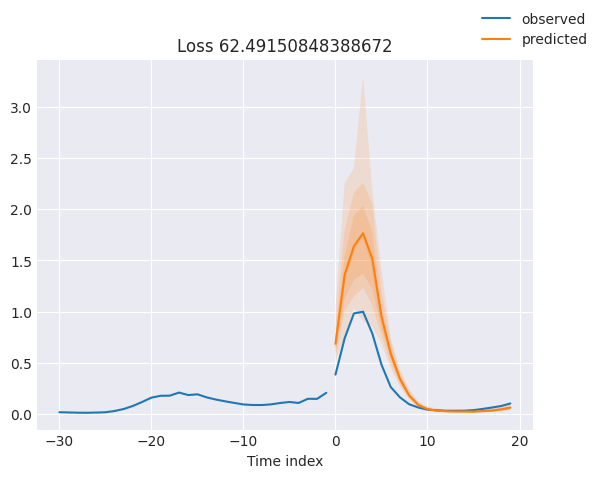

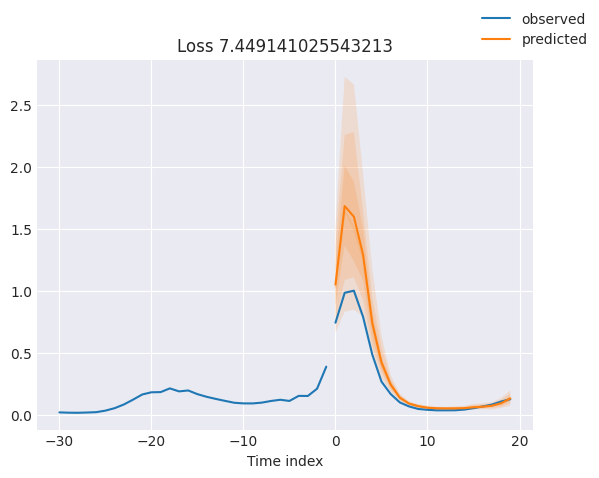

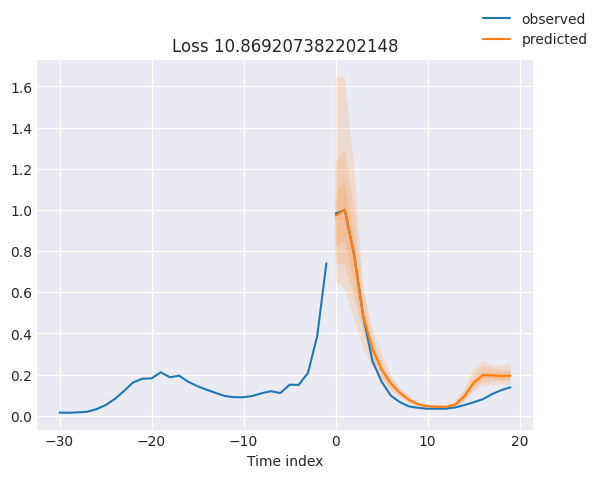

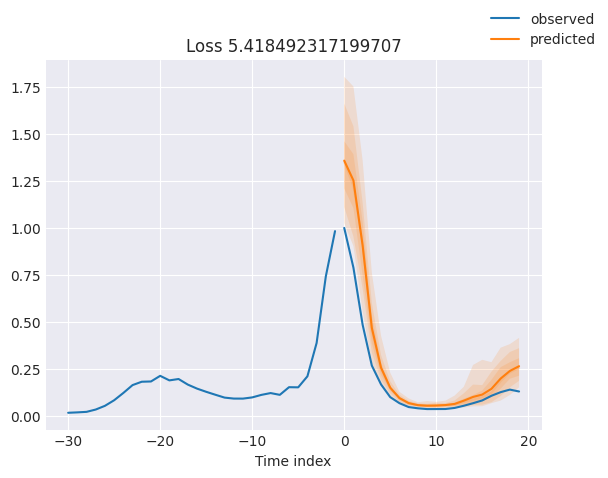

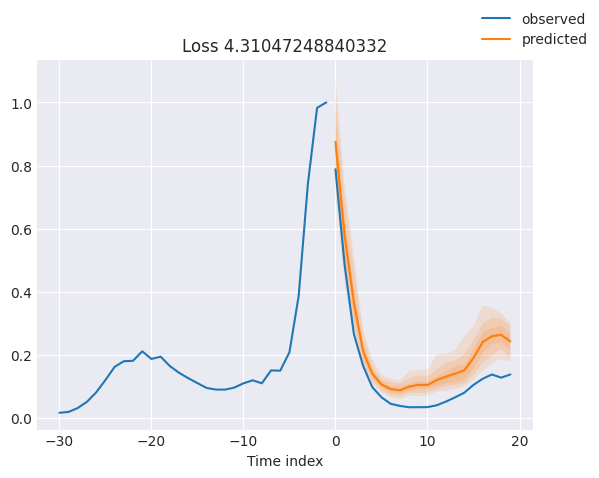

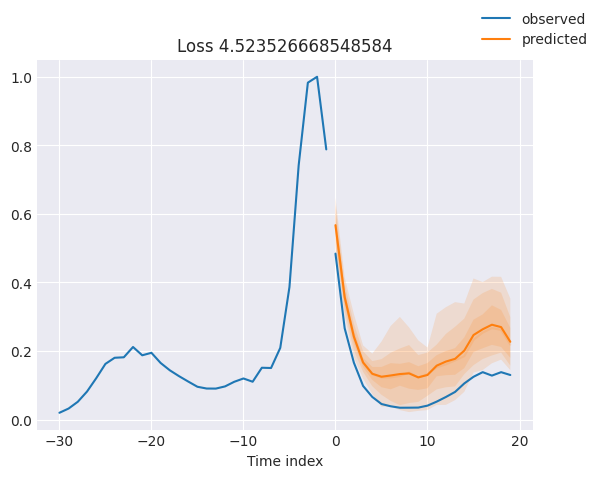

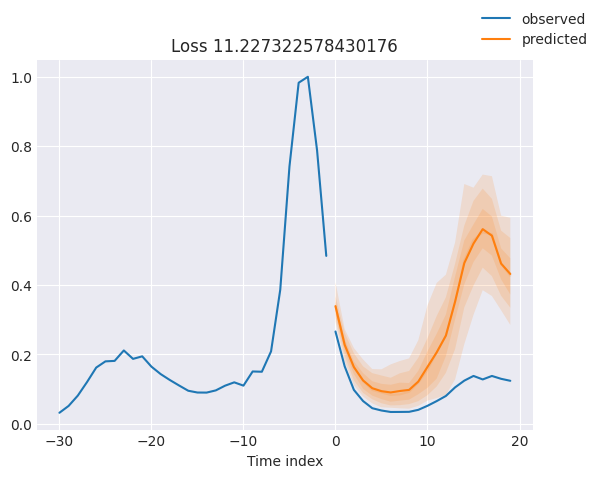

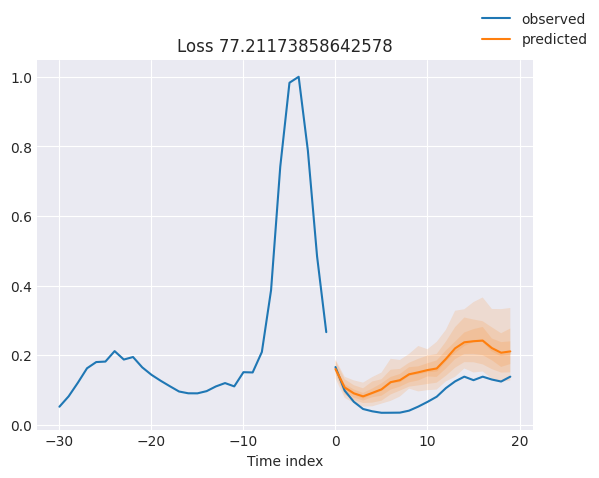

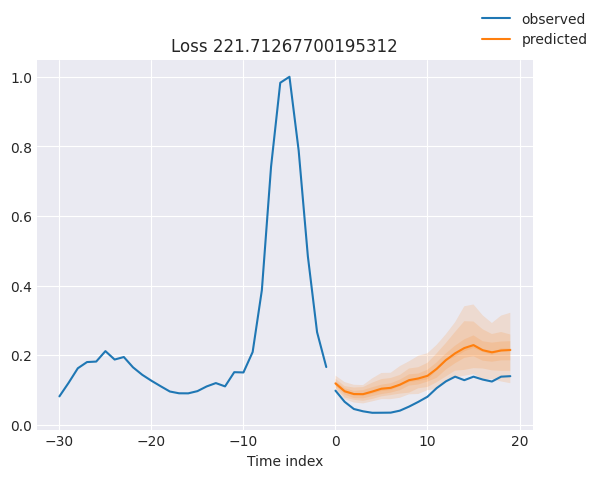

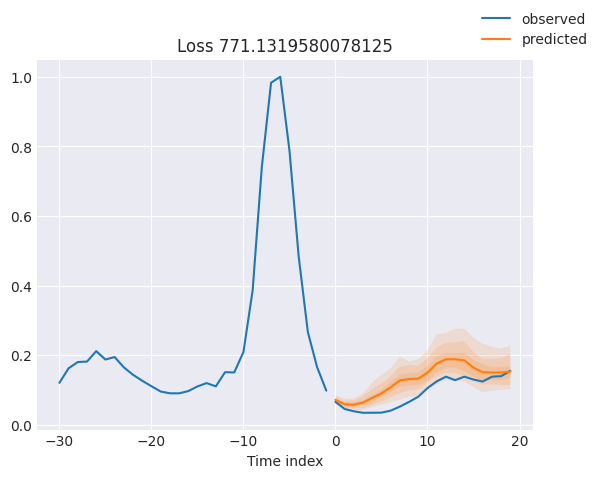

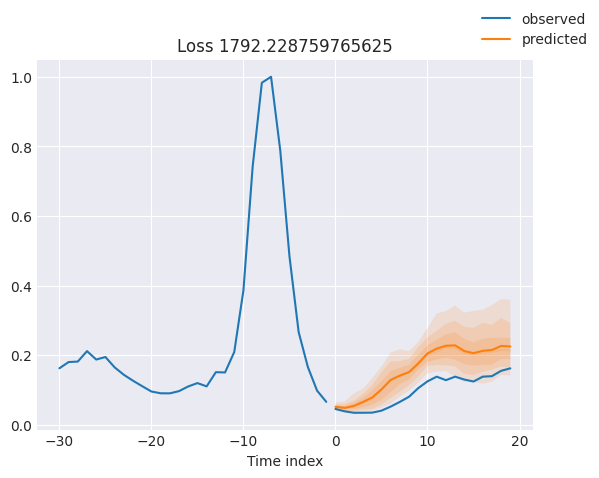

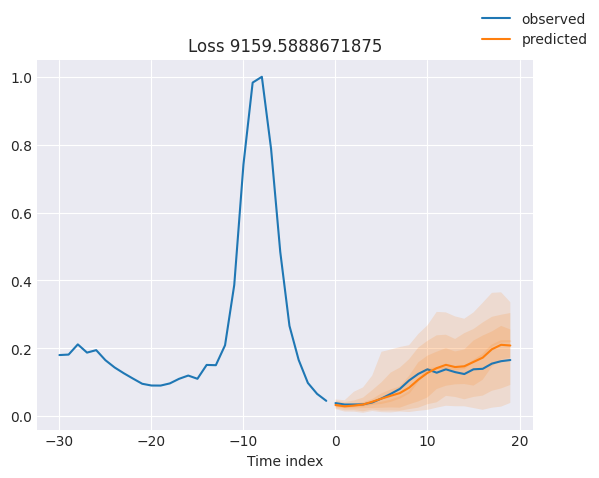

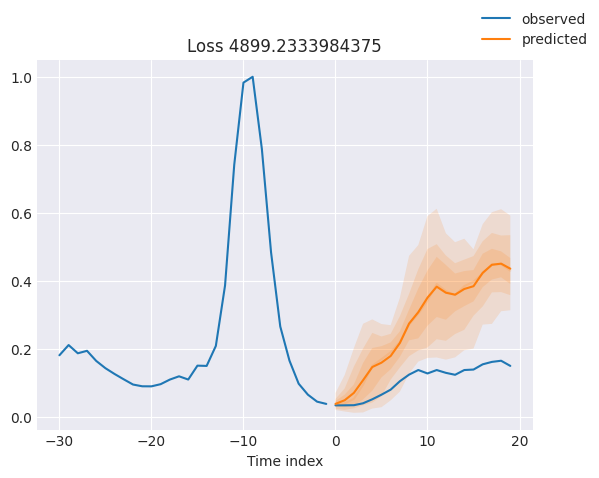

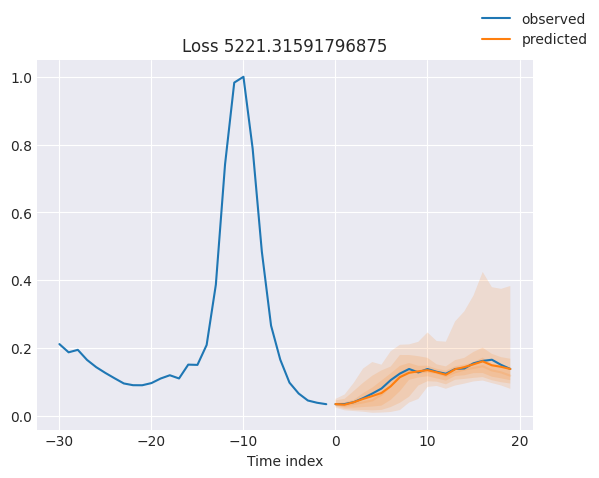

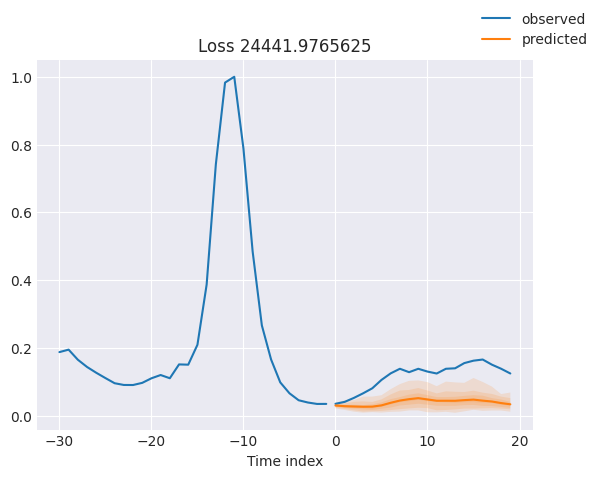

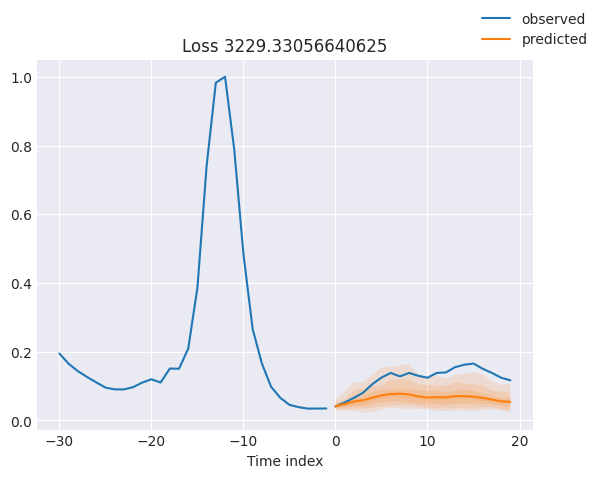

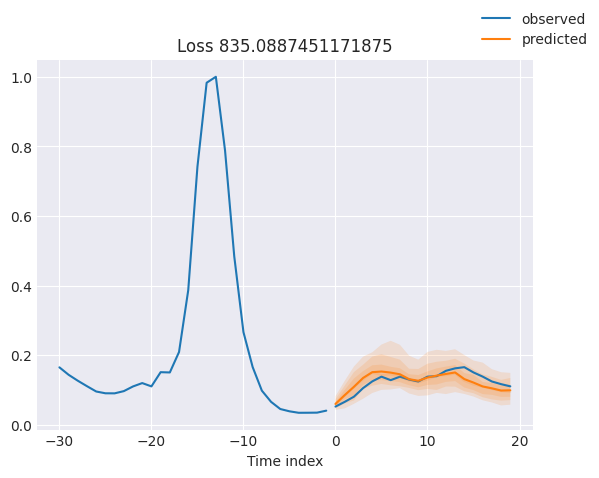

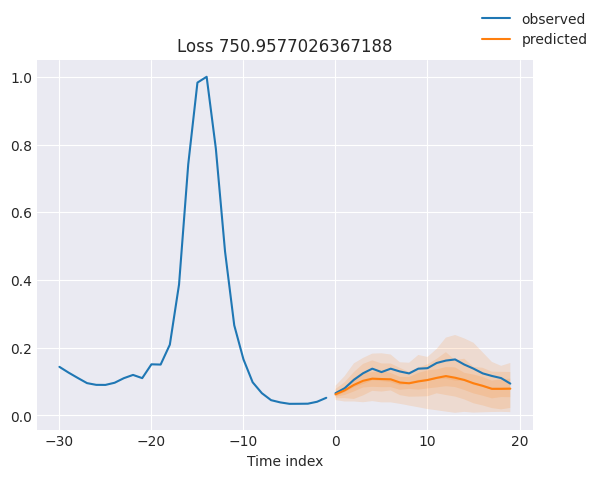

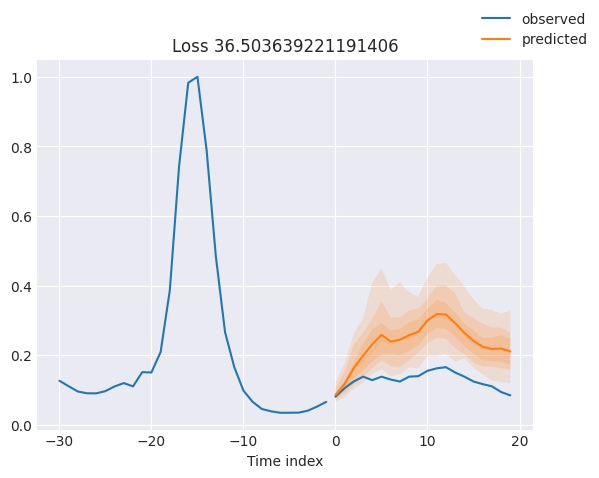

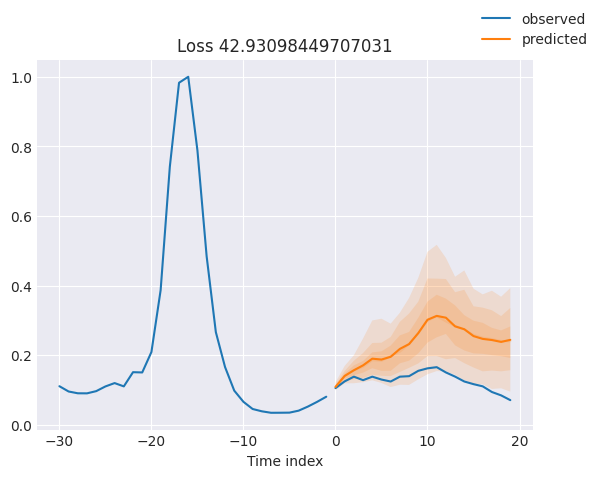

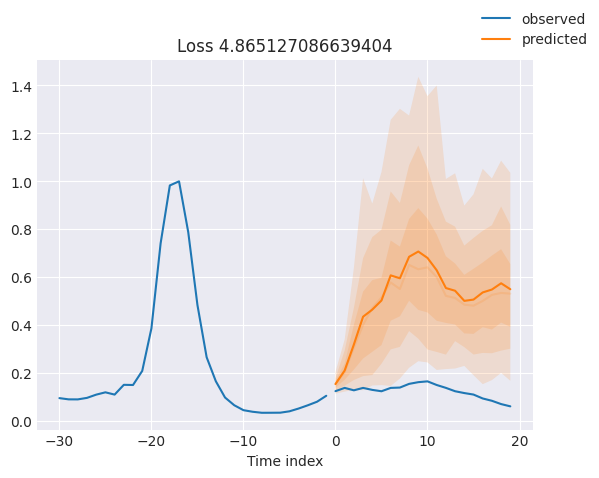

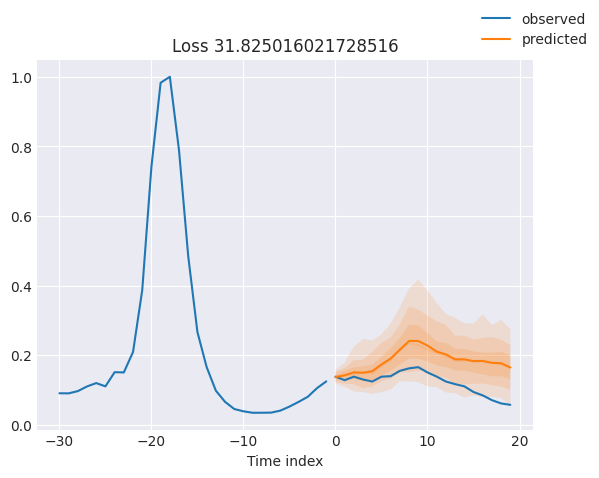

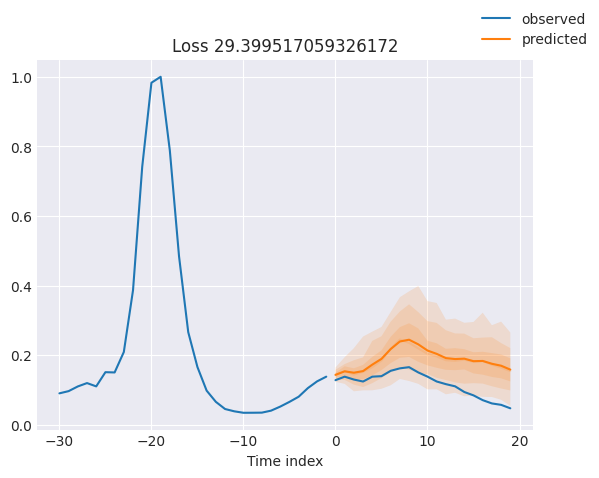

In [10]:
for n, window in enumerate(final_df.rolling(window=120, closed='right')):
    #print(len(window))
    if len(window) == 120:
        train_model(pd.DataFrame(window), n)


In [13]:
covid_data = pd.read_csv('Weekly_United_States_COVID-19_Cases_and_Deaths_by_State.csv')
for n, week in copy.copy(covid_data.groupby('date_updated')):
    week = week.reset_index(drop=True)
    tempdf = pd.DataFrame([[week.date_updated.loc[0], 'national', week.start_date.loc[0], week.end_date.loc[0], week.tot_cases.sum(), week.new_cases.sum(), week.tot_deaths.sum(), week.new_deaths.sum()]], columns = covid_data.columns)
    covid_data = pd.concat([covid_data, tempdf], ignore_index= True)

In [25]:

region = 'Georgia'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = (covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True))
covid_data_alb = covid_data.loc[covid_data.state == state_to_symbol["Alabama"]]['new_cases']
covid_normalized_alb = (covid_data_alb / covid_data_alb.max())
final_df_alb = pd.DataFrame(data=zip(covid_normalized_alb, ageusia_normalized, hypoxemia_normalized, lgfever_normalized,  range(len(covid_normalized_alb))) , columns=['cases', 'ageusia', 'hypoxemia', 'lgfever', 'dates'])

Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 22/22 [00:00<00:00, 25.56it/s, loss=-2.5, v_num=104, train_loss_step=-2.28, val_loss=-2.88, train_loss_epoch=-2.53]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:00<00:00, 24.68it/s, loss=-2.5, v_num=104, train_loss_step=-2.28, val_loss=-2.88, train_loss_epoch=-2.53]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (22) is smaller than t

Epoch 27: 100%|██████████| 23/23 [00:00<00:00, 26.07it/s, loss=-2.39, v_num=105, train_loss_step=-2.85, val_loss=-2.94, train_loss_epoch=-2.41] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (23) is smaller than t

Epoch 29: 100%|██████████| 24/24 [00:01<00:00, 18.28it/s, loss=-2.46, v_num=106, train_loss_step=-2.60, val_loss=-1.33, train_loss_epoch=-2.47] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 24/24 [00:01<00:00, 17.77it/s, loss=-2.46, v_num=106, train_loss_step=-2.60, val_loss=-1.33, train_loss_epoch=-2.47]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 14: 100%|██████████| 25/25 [00:01<00:00, 21.51it/s, loss=-2.09, v_num=107, train_loss_step=-1.67, val_loss=-1.12, train_loss_epoch=-2.08] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 15: 100%|██████████| 26/26 [00:00<00:00, 26.37it/s, loss=-2.17, v_num=108, train_loss_step=-1.90, val_loss=0.0823, train_loss_epoch=-2.17]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 17: 100%|██████████| 27/27 [00:01<00:00, 26.40it/s, loss=-1.86, v_num=109, train_loss_step=-2.16, val_loss=-2.01, train_loss_epoch=-1.85]  


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (27) is smaller than t

Epoch 18: 100%|██████████| 28/28 [00:01<00:00, 24.52it/s, loss=-2.34, v_num=110, train_loss_step=-1.94, val_loss=-1.35, train_loss_epoch=-2.27]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (28) is smaller than t

Epoch 29: 100%|██████████| 29/29 [00:00<00:00, 29.49it/s, loss=-2.32, v_num=111, train_loss_step=-2.36, val_loss=-3.29, train_loss_epoch=-2.40]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 29/29 [00:01<00:00, 28.66it/s, loss=-2.32, v_num=111, train_loss_step=-2.36, val_loss=-3.29, train_loss_epoch=-2.40]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (29) is smaller than t

Epoch 29: 100%|██████████| 30/30 [00:01<00:00, 26.44it/s, loss=-2.39, v_num=112, train_loss_step=-1.69, val_loss=-3.34, train_loss_epoch=-2.37]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 30/30 [00:01<00:00, 25.73it/s, loss=-2.39, v_num=112, train_loss_step=-1.69, val_loss=-3.34, train_loss_epoch=-2.37]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 31/31 [00:01<00:00, 23.78it/s, loss=-2.62, v_num=113, train_loss_step=-2.54, val_loss=-3.39, train_loss_epoch=-2.61]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 31/31 [00:01<00:00, 23.14it/s, loss=-2.62, v_num=113, train_loss_step=-2.54, val_loss=-3.39, train_loss_epoch=-2.61]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (31) is smaller than t

Epoch 29: 100%|██████████| 32/32 [00:01<00:00, 28.32it/s, loss=-2.85, v_num=114, train_loss_step=-1.54, val_loss=-3.74, train_loss_epoch=-2.85] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 32/32 [00:01<00:00, 27.42it/s, loss=-2.85, v_num=114, train_loss_step=-1.54, val_loss=-3.74, train_loss_epoch=-2.85]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (32) is smaller than t

Epoch 29: 100%|██████████| 33/33 [00:01<00:00, 23.17it/s, loss=-2.4, v_num=115, train_loss_step=-2.44, val_loss=-3.24, train_loss_epoch=-2.49] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 33/33 [00:01<00:00, 22.62it/s, loss=-2.4, v_num=115, train_loss_step=-2.44, val_loss=-3.24, train_loss_epoch=-2.49]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (33) is smaller than t

Epoch 29: 100%|██████████| 34/34 [00:01<00:00, 28.55it/s, loss=-2.87, v_num=116, train_loss_step=-2.38, val_loss=-2.87, train_loss_epoch=-2.88]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 34/34 [00:01<00:00, 27.80it/s, loss=-2.87, v_num=116, train_loss_step=-2.38, val_loss=-2.87, train_loss_epoch=-2.88]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 35/35 [00:01<00:00, 29.14it/s, loss=-2.52, v_num=117, train_loss_step=-2.94, val_loss=-3.31, train_loss_epoch=-2.60]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 35/35 [00:01<00:00, 28.46it/s, loss=-2.52, v_num=117, train_loss_step=-2.94, val_loss=-3.31, train_loss_epoch=-2.60]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (35) is smaller than t

Epoch 29: 100%|██████████| 36/36 [00:01<00:00, 29.22it/s, loss=-2.54, v_num=118, train_loss_step=-2.06, val_loss=-3.44, train_loss_epoch=-2.69]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 36/36 [00:01<00:00, 28.56it/s, loss=-2.54, v_num=118, train_loss_step=-2.06, val_loss=-3.44, train_loss_epoch=-2.69]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (36) is smaller than t

Epoch 29: 100%|██████████| 37/37 [00:01<00:00, 31.02it/s, loss=-2.59, v_num=119, train_loss_step=-2.48, val_loss=-2.82, train_loss_epoch=-2.67]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 37/37 [00:01<00:00, 30.29it/s, loss=-2.59, v_num=119, train_loss_step=-2.48, val_loss=-2.82, train_loss_epoch=-2.67]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (37) is smaller than t

Epoch 29: 100%|██████████| 38/38 [00:01<00:00, 30.24it/s, loss=-2.72, v_num=120, train_loss_step=-2.98, val_loss=-2.97, train_loss_epoch=-2.82]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 38/38 [00:01<00:00, 29.51it/s, loss=-2.72, v_num=120, train_loss_step=-2.98, val_loss=-2.97, train_loss_epoch=-2.82]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (38) is smaller than t

Epoch 29: 100%|██████████| 39/39 [00:01<00:00, 31.28it/s, loss=-2.89, v_num=121, train_loss_step=-2.87, val_loss=-3.17, train_loss_epoch=-2.97]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 39/39 [00:01<00:00, 30.60it/s, loss=-2.89, v_num=121, train_loss_step=-2.87, val_loss=-3.17, train_loss_epoch=-2.97]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 40/40 [00:01<00:00, 28.51it/s, loss=-2.6, v_num=122, train_loss_step=-2.79, val_loss=-2.79, train_loss_epoch=-2.57] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 40/40 [00:01<00:00, 27.95it/s, loss=-2.6, v_num=122, train_loss_step=-2.79, val_loss=-2.79, train_loss_epoch=-2.57]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (40) is smaller than t

Epoch 29: 100%|██████████| 41/41 [00:01<00:00, 34.37it/s, loss=-2.71, v_num=123, train_loss_step=-.755, val_loss=-2.63, train_loss_epoch=-2.70]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 41/41 [00:01<00:00, 33.60it/s, loss=-2.71, v_num=123, train_loss_step=-.755, val_loss=-2.63, train_loss_epoch=-2.70]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_forecasting/models/base_model.py:797: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: 

Epoch 29: 100%|██████████| 42/42 [00:01<00:00, 32.26it/s, loss=-2.94, v_num=124, train_loss_step=-3.65, val_loss=-2.24, train_loss_epoch=-2.75] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 42/42 [00:01<00:00, 31.55it/s, loss=-2.94, v_num=124, train_loss_step=-3.65, val_loss=-2.24, train_loss_epoch=-2.75]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (42) is smaller than t

Epoch 29: 100%|██████████| 43/43 [00:01<00:00, 27.06it/s, loss=-2.42, v_num=125, train_loss_step=-2.67, val_loss=-2.34, train_loss_epoch=-2.56] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 43/43 [00:01<00:00, 26.53it/s, loss=-2.42, v_num=125, train_loss_step=-2.67, val_loss=-2.34, train_loss_epoch=-2.56]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (42) is smaller than t

Epoch 29: 100%|██████████| 43/43 [00:01<00:00, 30.23it/s, loss=-2.42, v_num=126, train_loss_step=-2.67, val_loss=-2.15, train_loss_epoch=-2.56] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 43/43 [00:01<00:00, 29.62it/s, loss=-2.42, v_num=126, train_loss_step=-2.67, val_loss=-2.15, train_loss_epoch=-2.56]


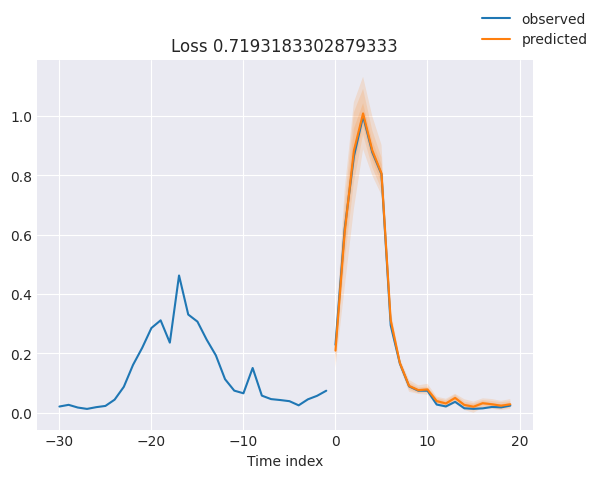

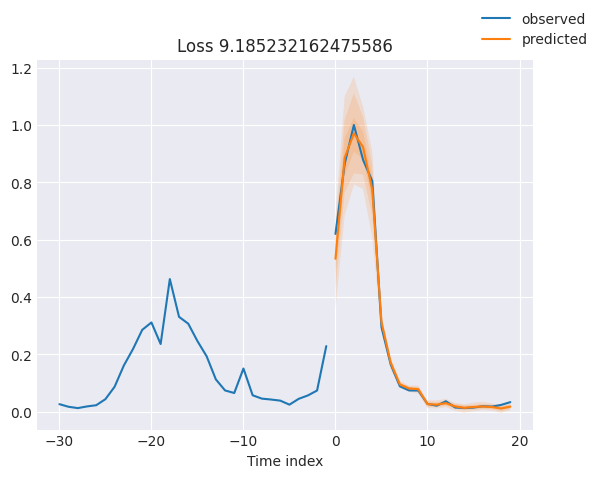

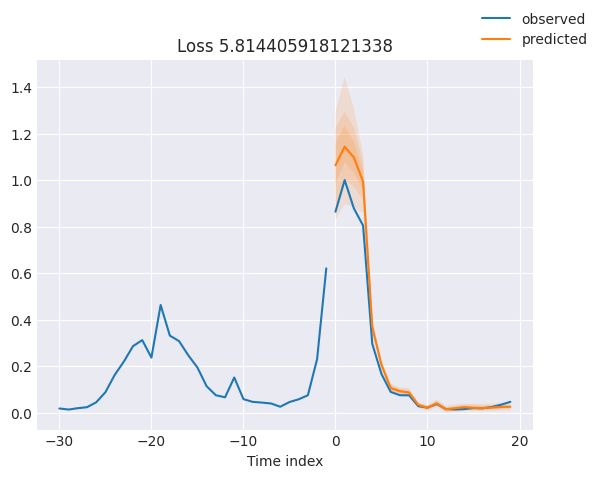

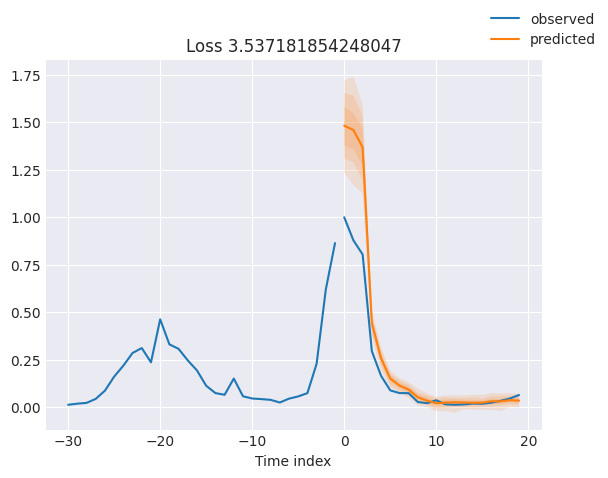

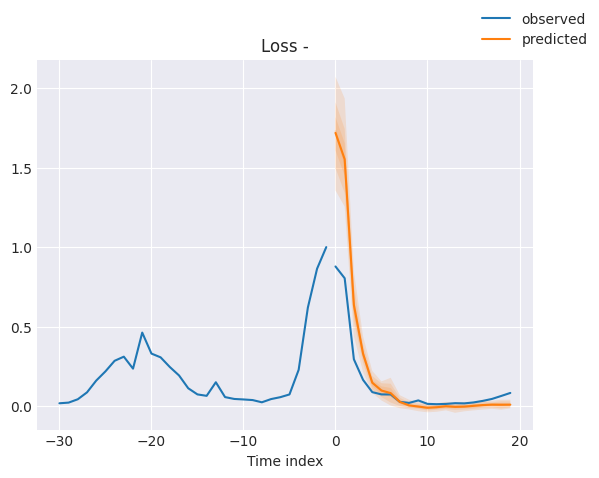

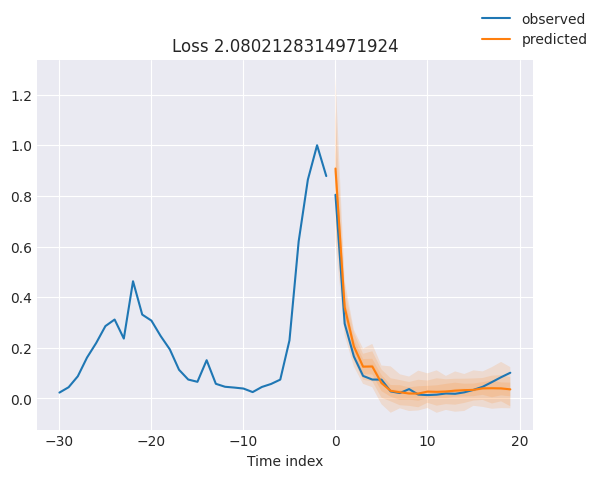

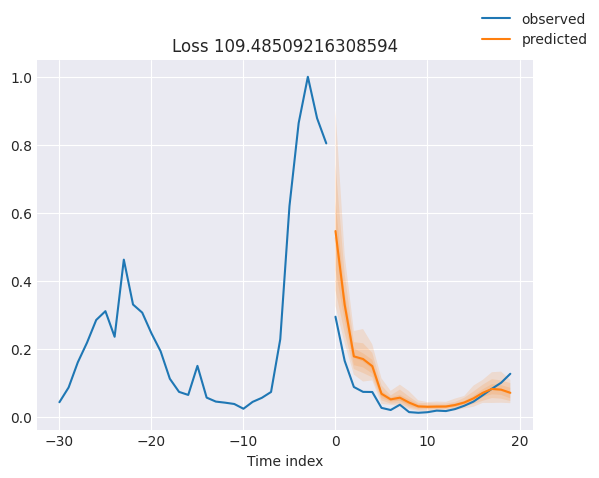

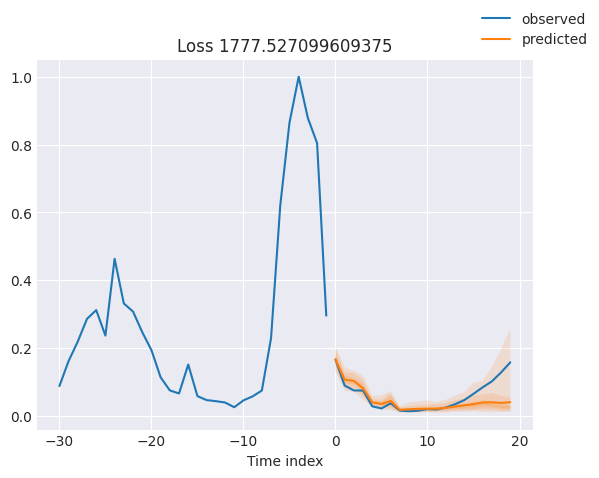

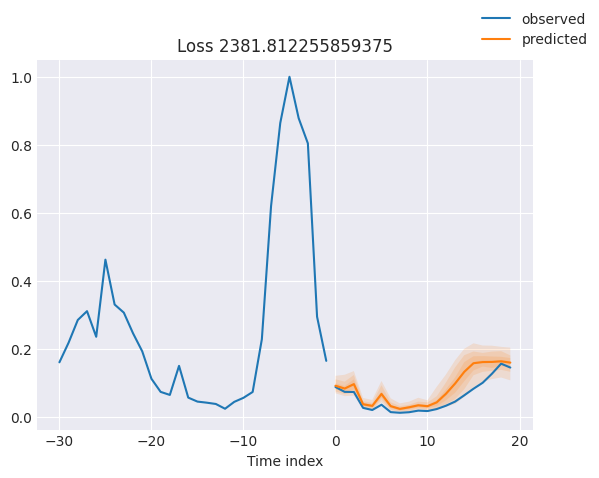

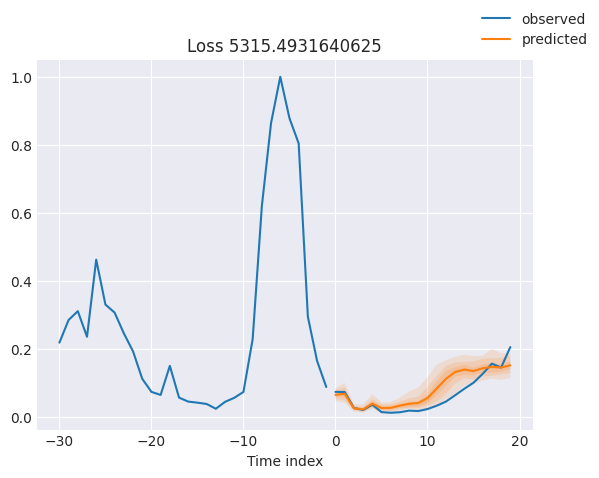

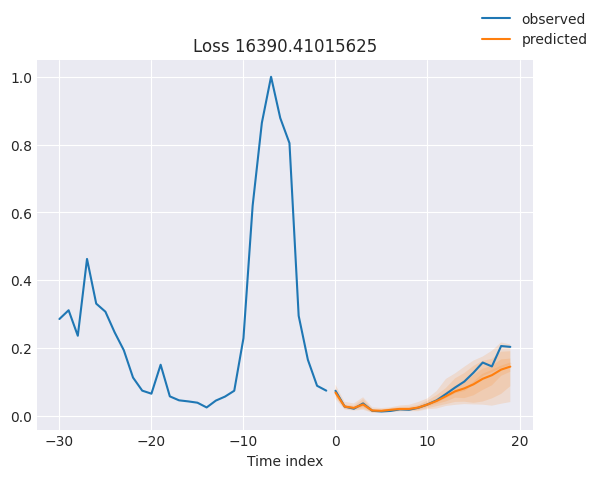

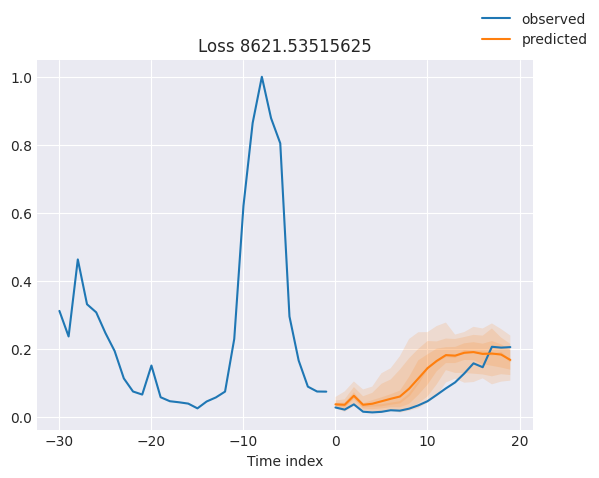

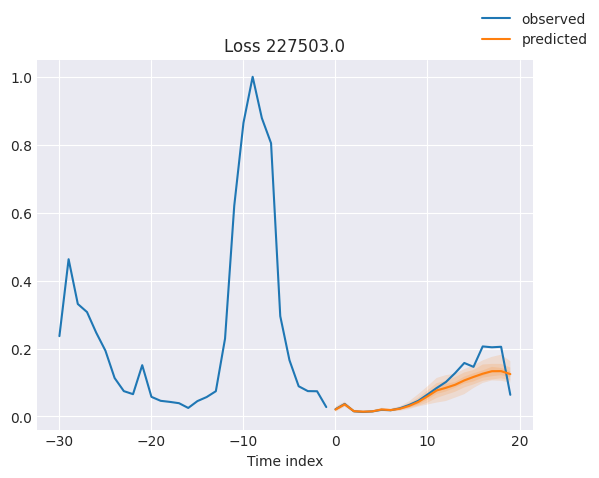

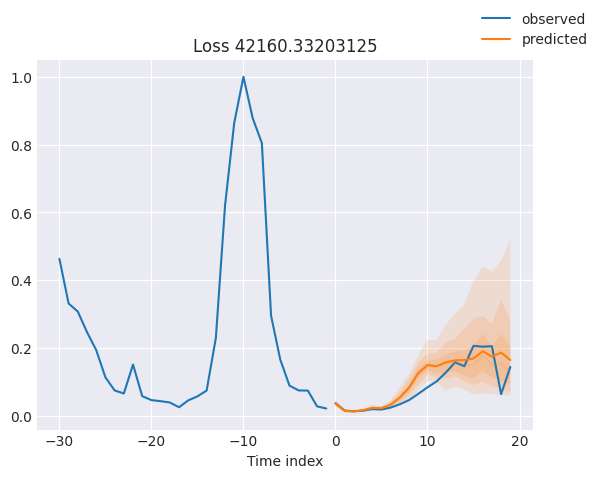

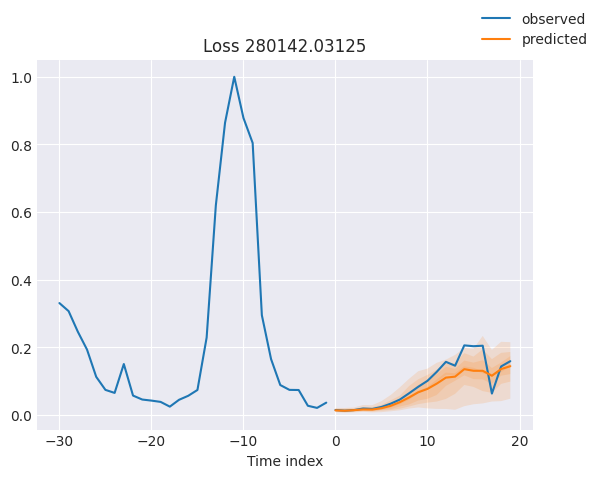

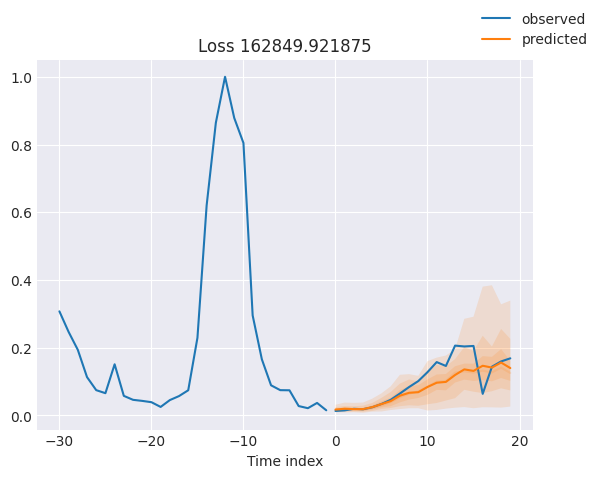

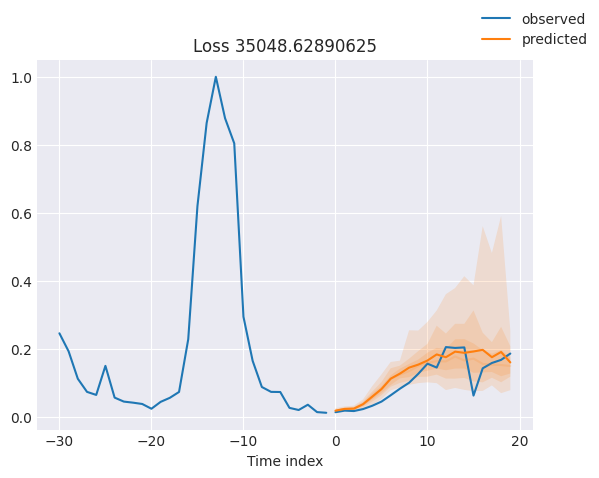

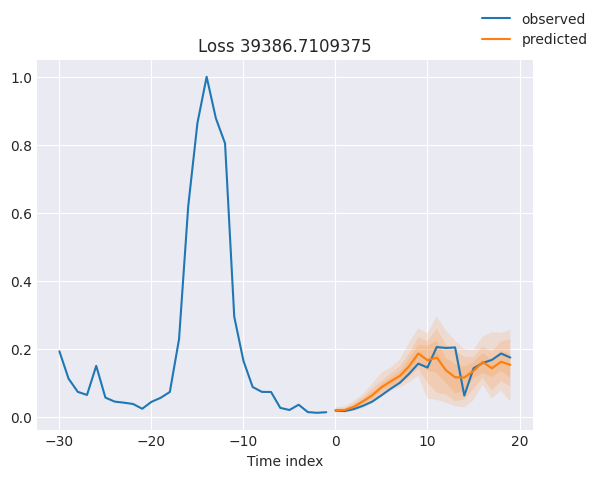

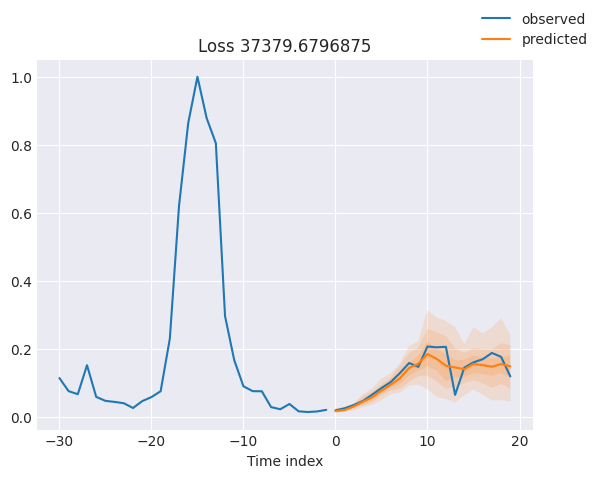

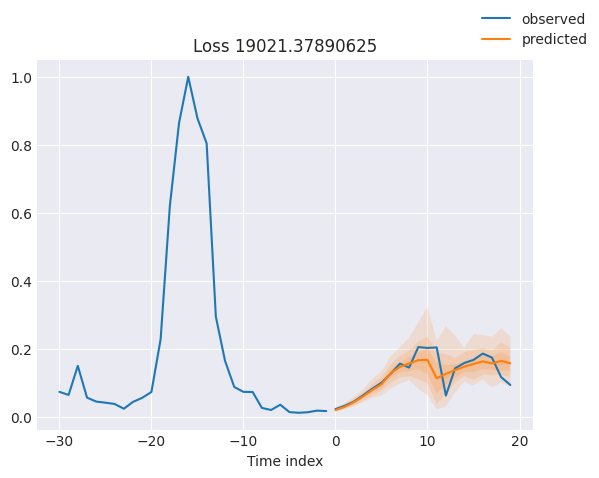

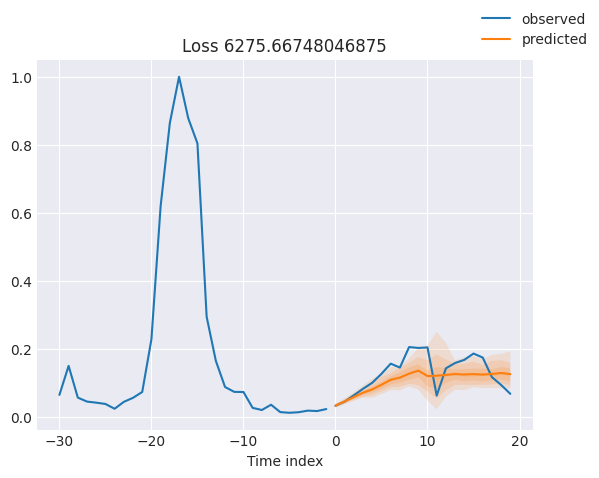

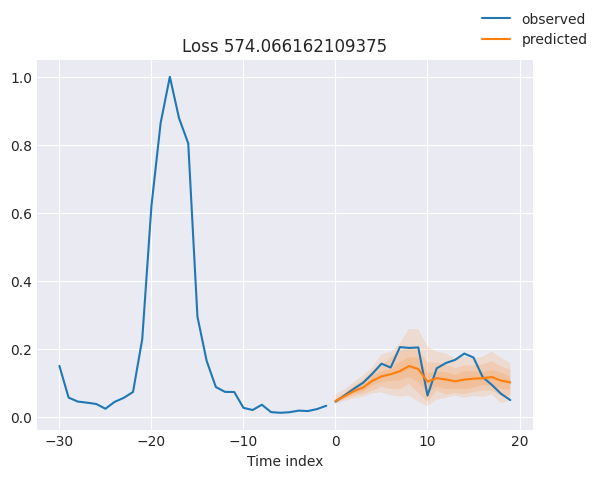

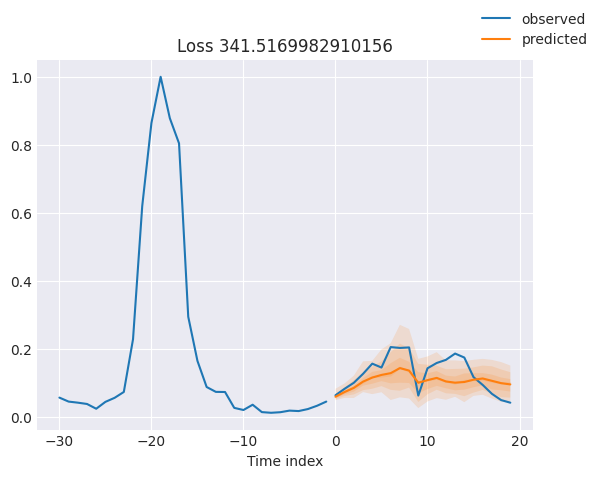

In [26]:
for n, window in enumerate(final_df_alb.rolling(window=120, closed='right')):
    #print(len(window))
    if len(window) == 120:
        train_model(pd.DataFrame(window), n, "Alabama")


In [12]:

region = 'Georgia'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = (covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True))
covid_data_sc = covid_data.loc[covid_data.state == state_to_symbol["South Carolina"]]['new_cases']
covid_normalized_sc = (covid_data_sc / covid_data_sc.max())
final_df_sc = pd.DataFrame(data=zip(covid_normalized_sc, ageusia_normalized, hypoxemia_normalized, lgfever_normalized, range(len(covid_normalized_sc))) , columns=['cases', 'ageusia', 'hypoxemia', 'lgfever', 'dates'])

Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (21) is smaller than t

Epoch 29: 100%|██████████| 22/22 [00:00<00:00, 38.72it/s, loss=-2.72, v_num=133, train_loss_step=-2.43, val_loss=-3.01, train_loss_epoch=-2.73] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:00<00:00, 37.06it/s, loss=-2.72, v_num=133, train_loss_step=-2.43, val_loss=-3.01, train_loss_epoch=-2.73]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (22) is smaller than t

Epoch 21: 100%|██████████| 23/23 [00:00<00:00, 36.66it/s, loss=-2.69, v_num=134, train_loss_step=-3.02, val_loss=-2.73, train_loss_epoch=-2.73] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (23) is smaller than t

Epoch 24: 100%|██████████| 24/24 [00:00<00:00, 36.23it/s, loss=-2.54, v_num=135, train_loss_step=-2.47, val_loss=-2.23, train_loss_epoch=-2.51] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (24) is smaller than t

Epoch 14: 100%|██████████| 25/25 [00:00<00:00, 37.69it/s, loss=-2.49, v_num=136, train_loss_step=-2.74, val_loss=-2.25, train_loss_epoch=-2.46]  


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (25) is smaller than t

Epoch 19: 100%|██████████| 26/26 [00:00<00:00, 37.36it/s, loss=-2.51, v_num=137, train_loss_step=-3.13, val_loss=-1.47, train_loss_epoch=-2.52] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (26) is smaller than t

Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 35.98it/s, loss=-2.66, v_num=138, train_loss_step=-3.00, val_loss=-2.44, train_loss_epoch=-2.60] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 34.69it/s, loss=-2.66, v_num=138, train_loss_step=-3.00, val_loss=-2.44, train_loss_epoch=-2.60]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (27) is smaller than t

Epoch 29: 100%|██████████| 28/28 [00:00<00:00, 39.44it/s, loss=-2.89, v_num=139, train_loss_step=-2.37, val_loss=-2.66, train_loss_epoch=-2.92] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 28/28 [00:00<00:00, 38.07it/s, loss=-2.89, v_num=139, train_loss_step=-2.37, val_loss=-2.66, train_loss_epoch=-2.92]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (28) is smaller than t

Epoch 29: 100%|██████████| 29/29 [00:00<00:00, 35.48it/s, loss=-2.96, v_num=140, train_loss_step=-2.22, val_loss=-3.46, train_loss_epoch=-2.88]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 29/29 [00:00<00:00, 34.40it/s, loss=-2.96, v_num=140, train_loss_step=-2.22, val_loss=-3.46, train_loss_epoch=-2.88]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (29) is smaller than t

Epoch 29: 100%|██████████| 30/30 [00:00<00:00, 34.31it/s, loss=-2.54, v_num=141, train_loss_step=-.198, val_loss=-.930, train_loss_epoch=-2.59] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 30/30 [00:00<00:00, 33.22it/s, loss=-2.54, v_num=141, train_loss_step=-.198, val_loss=-.930, train_loss_epoch=-2.59]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than t

Epoch 16: 100%|██████████| 31/31 [00:00<00:00, 31.63it/s, loss=-2.72, v_num=142, train_loss_step=-3.01, val_loss=-3.22, train_loss_epoch=-2.72]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (31) is smaller than t

Epoch 29: 100%|██████████| 32/32 [00:00<00:00, 35.95it/s, loss=-3.09, v_num=143, train_loss_step=-2.60, val_loss=-4.13, train_loss_epoch=-2.91] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 32/32 [00:00<00:00, 34.88it/s, loss=-3.09, v_num=143, train_loss_step=-2.60, val_loss=-4.13, train_loss_epoch=-2.91]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (32) is smaller than t

Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 36.81it/s, loss=-2.86, v_num=144, train_loss_step=-2.79, val_loss=-3.96, train_loss_epoch=-2.93]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 35.68it/s, loss=-2.86, v_num=144, train_loss_step=-2.79, val_loss=-3.96, train_loss_epoch=-2.93]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (33) is smaller than t

Epoch 25: 100%|██████████| 34/34 [00:01<00:00, 33.75it/s, loss=-3.09, v_num=145, train_loss_step=-3.01, val_loss=-3.79, train_loss_epoch=-3.06] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (34) is smaller than t

Epoch 29: 100%|██████████| 35/35 [00:00<00:00, 35.42it/s, loss=-2.94, v_num=146, train_loss_step=-2.99, val_loss=-3.63, train_loss_epoch=-2.99]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 35/35 [00:01<00:00, 34.43it/s, loss=-2.94, v_num=146, train_loss_step=-2.99, val_loss=-3.63, train_loss_epoch=-2.99]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (35) is smaller than t

Epoch 29: 100%|██████████| 36/36 [00:00<00:00, 36.51it/s, loss=-2.62, v_num=147, train_loss_step=-2.71, val_loss=-3.03, train_loss_epoch=-2.79]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 36/36 [00:01<00:00, 35.47it/s, loss=-2.62, v_num=147, train_loss_step=-2.71, val_loss=-3.03, train_loss_epoch=-2.79]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (36) is smaller than t

Epoch 29: 100%|██████████| 37/37 [00:01<00:00, 34.12it/s, loss=-3.03, v_num=148, train_loss_step=-3.21, val_loss=-3.37, train_loss_epoch=-3.00]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 37/37 [00:01<00:00, 33.26it/s, loss=-3.03, v_num=148, train_loss_step=-3.21, val_loss=-3.37, train_loss_epoch=-3.00]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (37) is smaller than t

Epoch 15: 100%|██████████| 38/38 [00:01<00:00, 35.03it/s, loss=-2.9, v_num=149, train_loss_step=-2.68, val_loss=-1.41, train_loss_epoch=-2.80]  


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (38) is smaller than t

Epoch 29: 100%|██████████| 39/39 [00:01<00:00, 35.24it/s, loss=-2.78, v_num=150, train_loss_step=-2.76, val_loss=-2.99, train_loss_epoch=-2.87]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 39/39 [00:01<00:00, 34.24it/s, loss=-2.78, v_num=150, train_loss_step=-2.76, val_loss=-2.99, train_loss_epoch=-2.87]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (39) is smaller than t

Epoch 16: 100%|██████████| 40/40 [00:01<00:00, 33.48it/s, loss=-2.53, v_num=151, train_loss_step=-3.17, val_loss=-2.51, train_loss_epoch=-2.68]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (40) is smaller than t

Epoch 15: 100%|██████████| 41/41 [00:01<00:00, 34.32it/s, loss=-2.5, v_num=152, train_loss_step=-2.62, val_loss=-2.69, train_loss_epoch=-2.71] 


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_forecasting/models/base_model.py:797: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: 

Epoch 29: 100%|██████████| 42/42 [00:01<00:00, 36.65it/s, loss=-3.04, v_num=153, train_loss_step=-3.39, val_loss=-2.81, train_loss_epoch=-2.88] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 42/42 [00:01<00:00, 35.79it/s, loss=-3.04, v_num=153, train_loss_step=-3.39, val_loss=-2.81, train_loss_epoch=-2.88]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (42) is smaller than t

Epoch 29: 100%|██████████| 43/43 [00:01<00:00, 33.90it/s, loss=-3.11, v_num=154, train_loss_step=-3.06, val_loss=-3.12, train_loss_epoch=-2.94]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 43/43 [00:01<00:00, 33.19it/s, loss=-3.11, v_num=154, train_loss_step=-3.06, val_loss=-3.12, train_loss_epoch=-2.94]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 43/43 [00:01<00:00, 39.39it/s, loss=-3.11, v_num=155, train_loss_step=-3.06, val_loss=-3.16, train_loss_epoch=-2.94]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 43/43 [00:01<00:00, 38.40it/s, loss=-3.11, v_num=155, train_loss_step=-3.06, val_loss=-3.16, train_loss_epoch=-2.94]


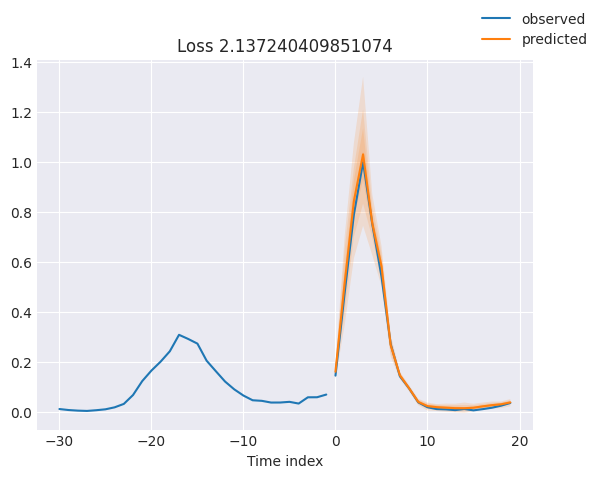

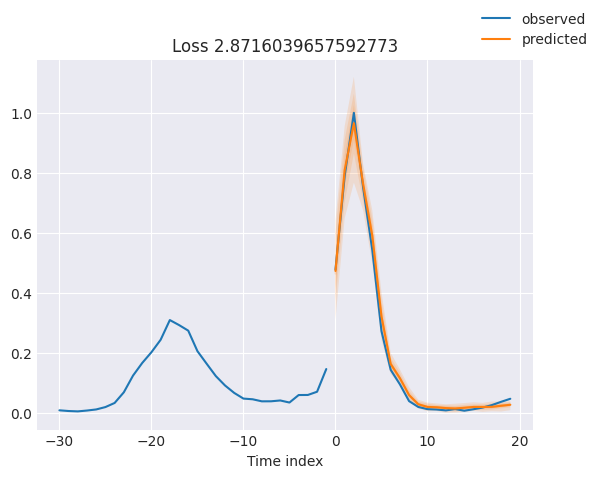

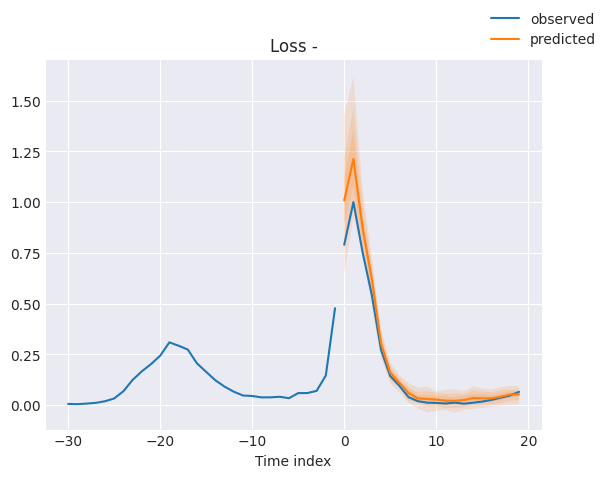

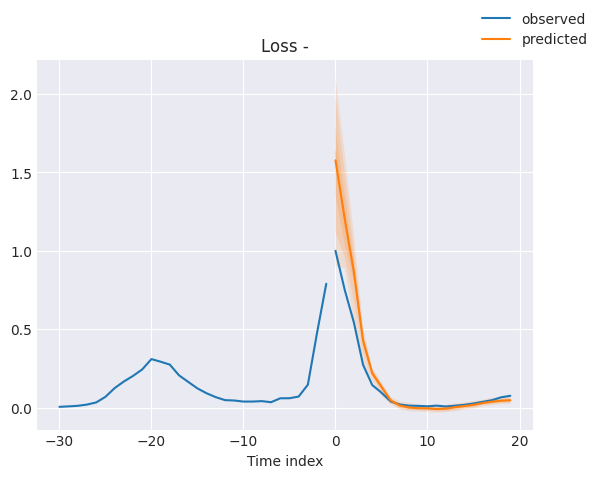

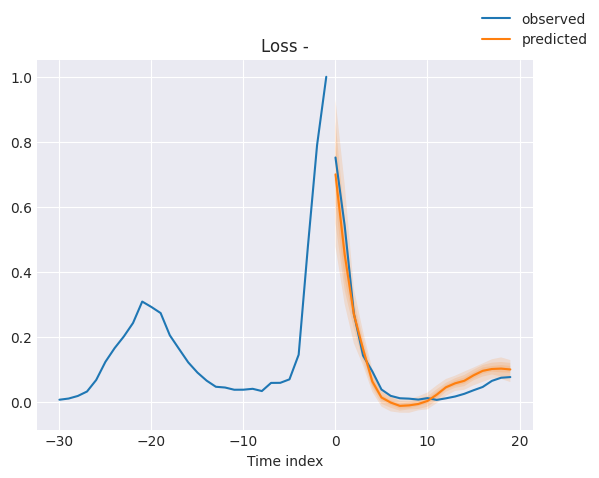

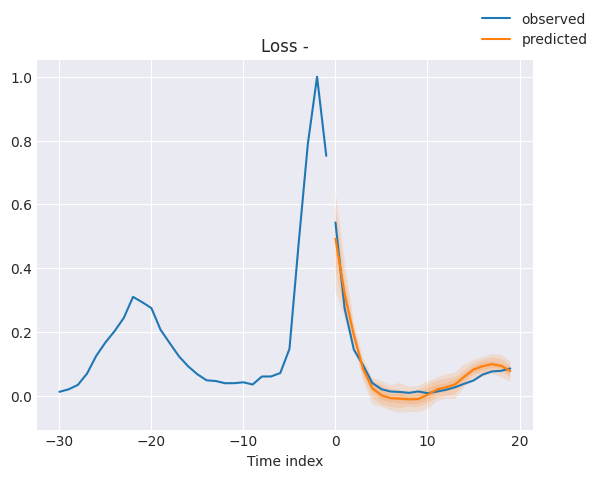

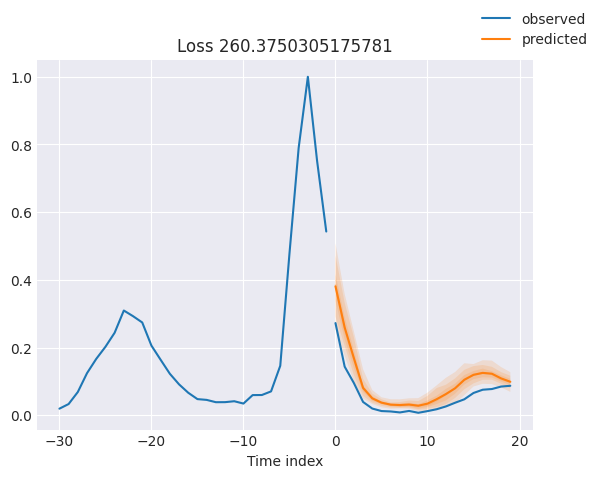

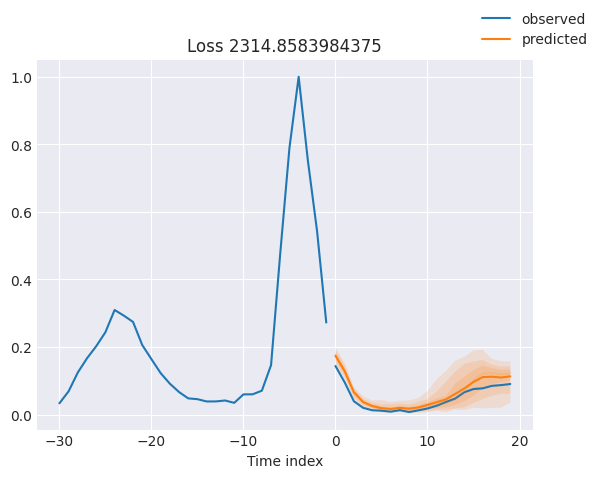

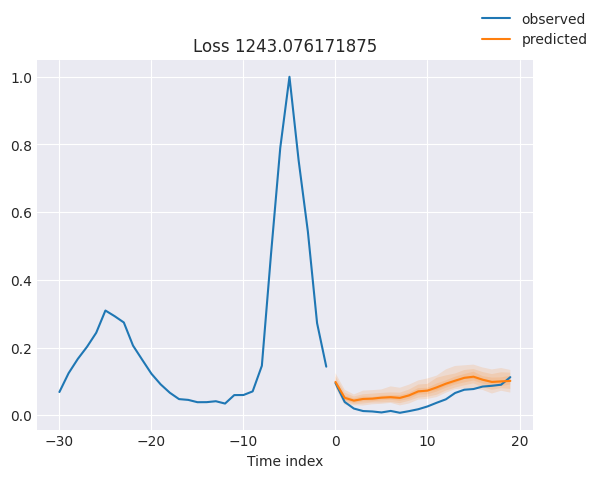

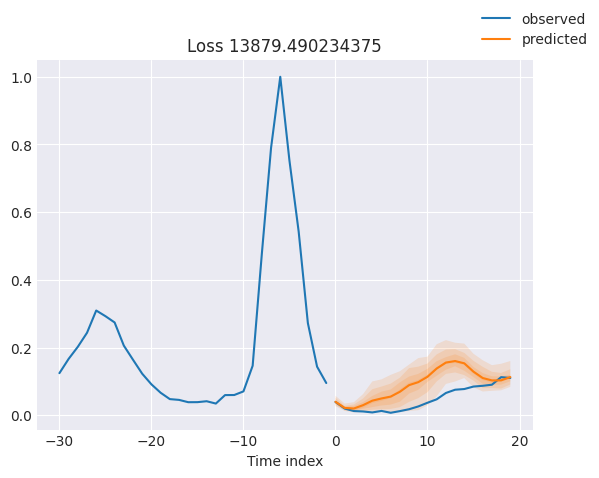

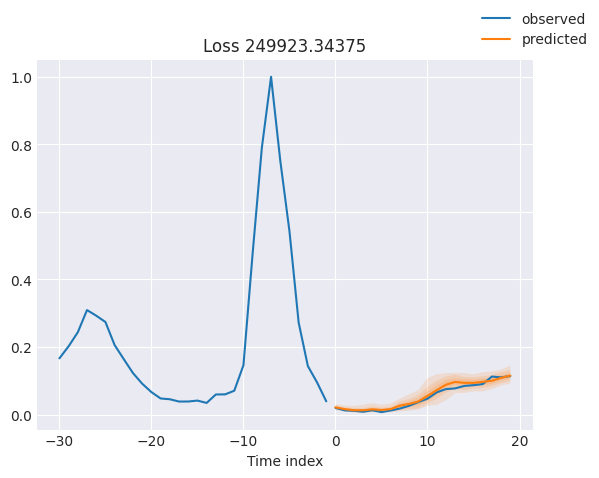

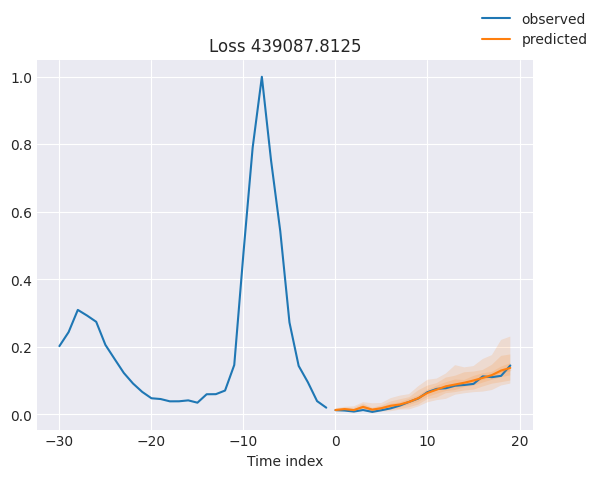

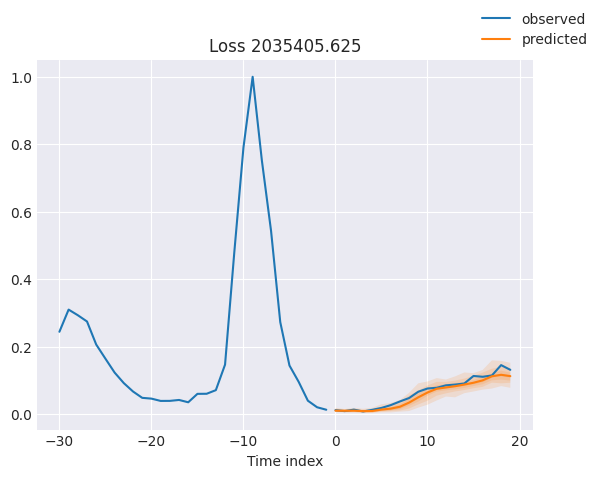

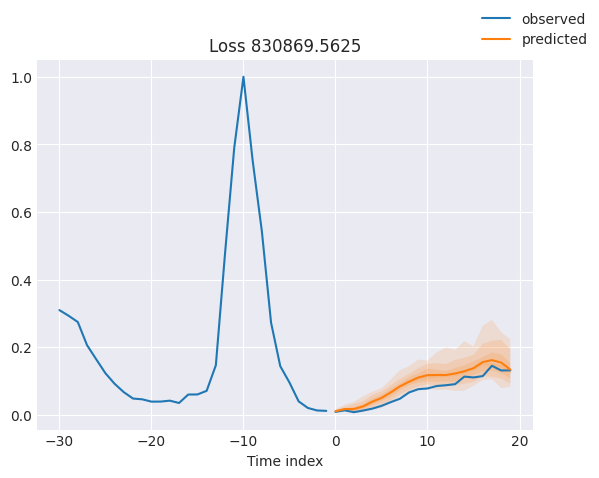

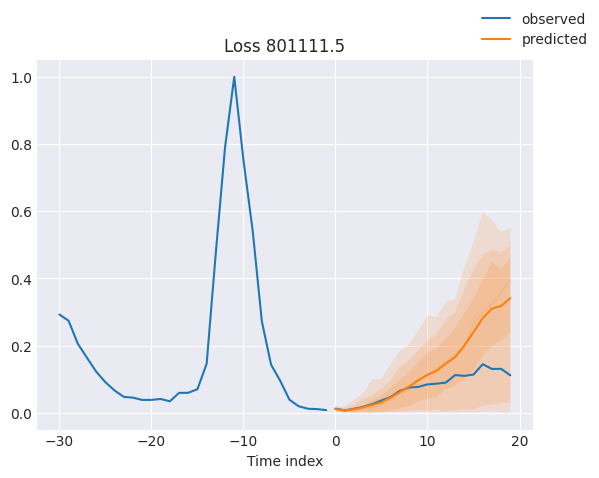

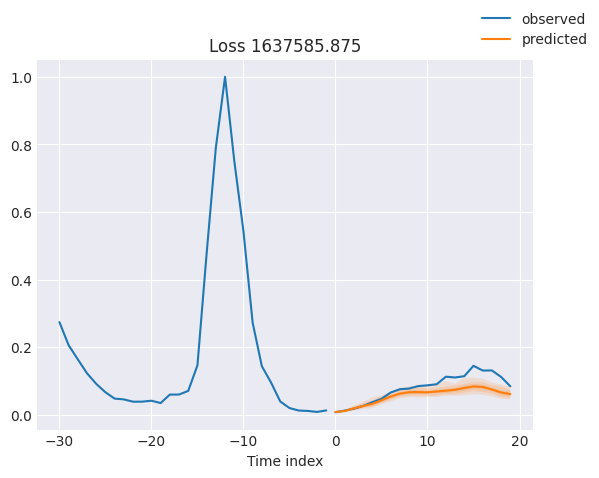

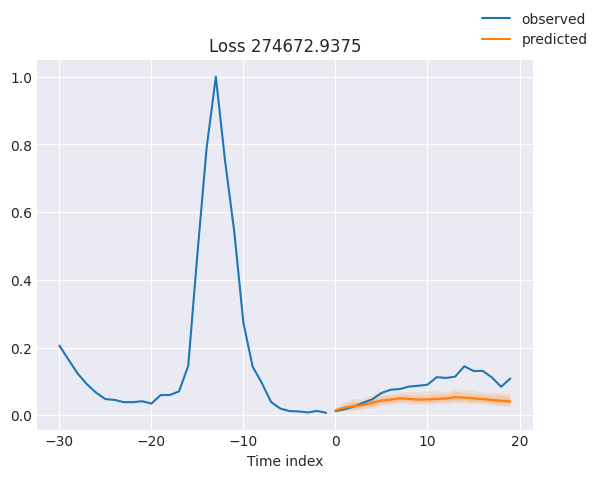

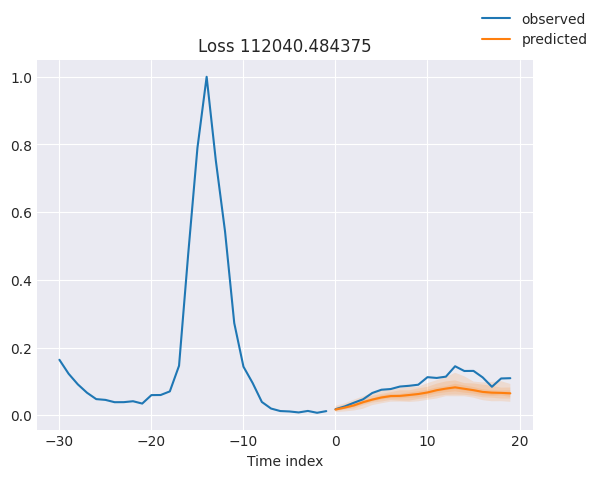

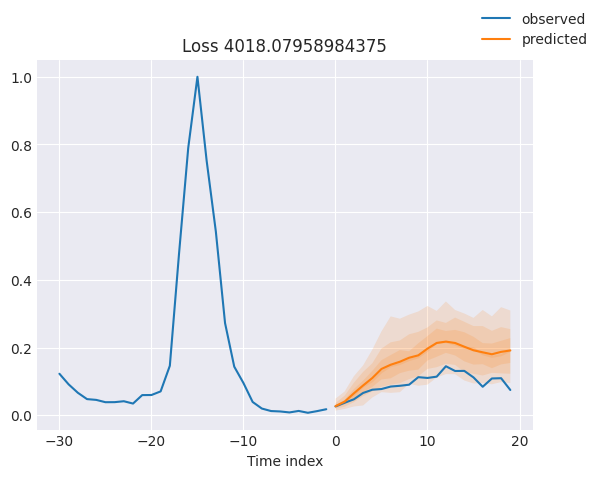

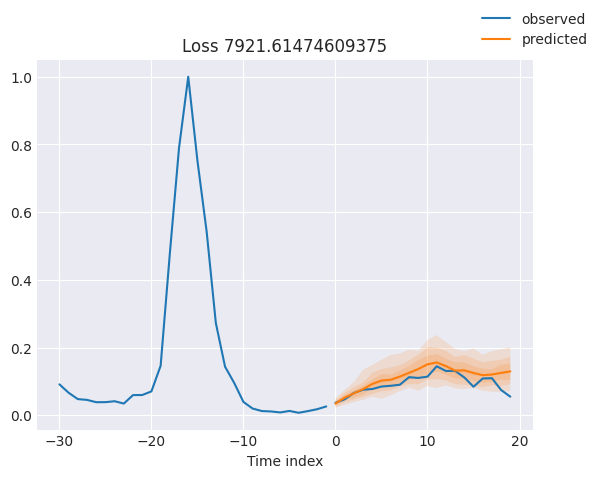

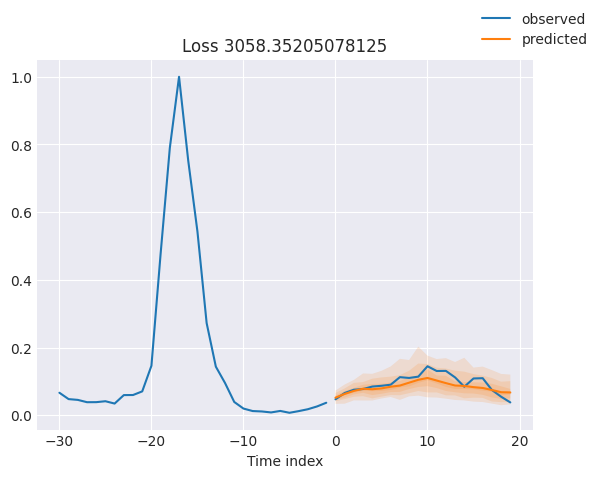

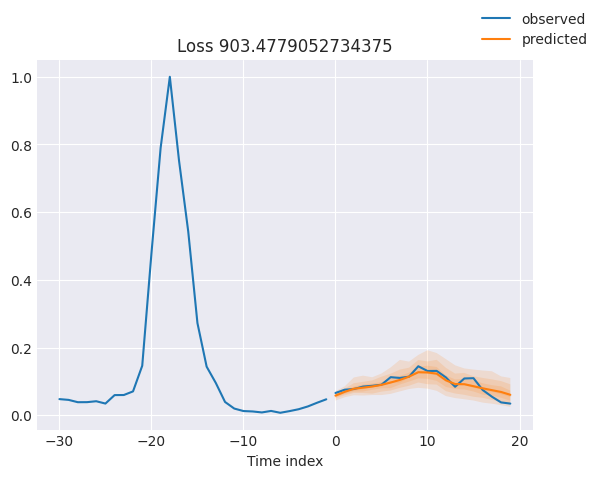

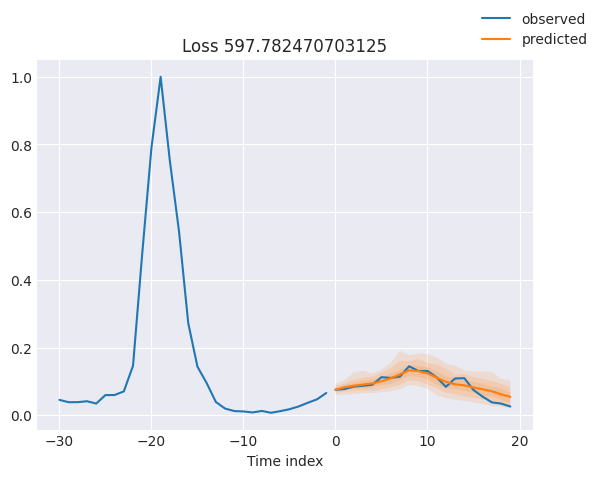

In [15]:
for n, window in enumerate(final_df_sc.rolling(window=120, closed='right')):
    #print(len(window))
    if len(window) == 120:
        train_model(pd.DataFrame(window), n, "SC")


# TF

In [107]:
def train_tf_model(dat, num, region="national"):
    # create dataset and dataloaders
    max_encoder_length = 30
    max_prediction_length = 20
    final_df = dat
    data = final_df
    data['series'] = [0 for x in range(len(final_df.dates.to_numpy()))]
    data = data.astype(dict(series=str))
    training_cutoff = data["dates"].max() - max_prediction_length

    context_length = max_encoder_length
    prediction_length = max_prediction_length

    training = TimeSeriesDataSet(
        data[lambda x: x.dates <= 140],
        time_idx="dates",
        target="cases",
        group_ids=["series"],
        static_categoricals=[
            "series"
            
        ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
        categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
        time_varying_unknown_reals=["cases"],
        time_varying_known_reals=["ageusia", "hypoxemia", "lgfever"],
        max_encoder_length=context_length,
        max_prediction_length=prediction_length,
        min_prediction_idx = 80,
        predict_mode=False
    )

    validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
    batch_size = 128
    # synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
    train_dataloader = training.to_dataloader(
        train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
    )
    val_dataloader = validation.to_dataloader(
        train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
    )
    pl.seed_everything(42)
    trainer = pl.Trainer(gpus=1, gradient_clip_val=1e-1)
    tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=MultivariateNormalDistributionLoss(rank=30),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
    # find optimal learning rate

    trainer = pl.Trainer(
        max_epochs=20,
        gpus=0,
        enable_model_summary=True,
        gradient_clip_val=0.1,
        limit_train_batches=30,  # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    )


    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.03,
        hidden_size=8,
        attention_head_size=1,
        dropout=0.1,
        hidden_continuous_size=8,
        output_size=7,  # 7 quantiles by default
        loss=MultivariateNormalDistributionLoss(rank=30),
        log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience=4,
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
    best_model_path = trainer.checkpoint_callback.best_model_path
    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_tft.predict(val_dataloader)
    (actuals - predictions).abs().mean()
    raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
    for idx in range(1):  # plot 10 examples
        best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plt.savefig(f"{region}/Window_{region}_{n}_tf.png")

In [108]:
covid_data = pd.read_csv('Weekly_United_States_COVID-19_Cases_and_Deaths_by_State.csv')
for n, week in copy.copy(covid_data.groupby('date_updated')):
    week = week.reset_index(drop=True)
    tempdf = pd.DataFrame([[week.date_updated.loc[0], 'national', week.start_date.loc[0], week.end_date.loc[0], week.tot_cases.sum(), week.new_cases.sum(), week.tot_deaths.sum(), week.new_deaths.sum()]], columns = covid_data.columns)
    covid_data = pd.concat([covid_data, tempdf], ignore_index= True)

In [109]:

region = 'Georgia'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = (covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True))
covid_data_alb = covid_data.loc[covid_data.state == state_to_symbol["Alabama"]]['new_cases']
covid_normalized_alb = (covid_data_alb / covid_data_alb.max())
final_df_alb = pd.DataFrame(data=zip(covid_normalized_alb, ageusia_normalized, hypoxemia_normalized, lgfever_normalized,  range(len(covid_normalized_alb))) , columns=['cases', 'ageusia', 'hypoxemia', 'lgfever', 'dates'])

In [110]:
for n, window in enumerate(final_df_alb.rolling(window=120, closed='right')):
    #print(len(window))
    if len(window) == 120:
        train_tf_model(pd.DataFrame(window), n, "Alabama")


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking: 0it [00:00, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s, loss=-1.91, v_num=261, train_loss_step=-2.01, val_loss=-2.26, train_loss_epoch=-1.91]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:02<00:00,  7.89it/s, loss=-1.91, v_num=261, train_loss_step=-2.01, val_loss=-2.26, train_loss_epoch=-1.91]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 23/23 [00:02<00:00,  8.73it/s, loss=-1.84, v_num=262, train_loss_step=-2.14, val_loss=-2.21, train_loss_epoch=-1.87]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s, loss=-1.84, v_num=262, train_loss_step=-2.14, val_loss=-2.21, train_loss_epoch=-1.87]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectio

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 24/24 [00:02<00:00,  8.57it/s, loss=-1.91, v_num=263, train_loss_step=-1.93, val_loss=-2.34, train_loss_epoch=-1.94]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:02<00:00,  8.29it/s, loss=-1.91, v_num=263, train_loss_step=-1.93, val_loss=-2.34, train_loss_epoch=-1.94]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  8.24it/s, loss=-2.06, v_num=264, train_loss_step=-2.07, val_loss=-2.14, train_loss_epoch=-2.05]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  7.97it/s, loss=-2.06, v_num=264, train_loss_step=-2.07, val_loss=-2.14, train_loss_epoch=-2.05]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  8.52it/s, loss=-1.79, v_num=265, train_loss_step=-2.26, val_loss=-1.42, train_loss_epoch=-1.77]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  8.24it/s, loss=-1.79, v_num=265, train_loss_step=-2.26, val_loss=-1.42, train_loss_epoch=-1.77]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 27/27 [00:03<00:00,  8.56it/s, loss=-2.1, v_num=266, train_loss_step=-1.29, val_loss=-1.34, train_loss_epoch=-2.07]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 27/27 [00:03<00:00,  8.29it/s, loss=-2.1, v_num=266, train_loss_step=-1.29, val_loss=-1.34, train_loss_epoch=-2.07]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectio

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 28/28 [00:03<00:00,  9.07it/s, loss=-2.2, v_num=267, train_loss_step=-2.17, val_loss=-2.01, train_loss_epoch=-2.22] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 28/28 [00:03<00:00,  8.80it/s, loss=-2.2, v_num=267, train_loss_step=-2.17, val_loss=-2.01, train_loss_epoch=-2.22]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 29/29 [00:03<00:00,  8.97it/s, loss=-2.33, v_num=268, train_loss_step=-1.88, val_loss=-2.52, train_loss_epoch=-2.26]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 29/29 [00:03<00:00,  8.71it/s, loss=-2.33, v_num=268, train_loss_step=-1.88, val_loss=-2.52, train_loss_epoch=-2.26]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 30/30 [00:03<00:00,  9.44it/s, loss=-2.28, v_num=269, train_loss_step=-1.87, val_loss=-2.89, train_loss_epoch=-2.27]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 30/30 [00:03<00:00,  9.16it/s, loss=-2.28, v_num=269, train_loss_step=-1.87, val_loss=-2.89, train_loss_epoch=-2.27]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  8.81it/s, loss=-2.26, v_num=270, train_loss_step=-2.50, val_loss=-2.80, train_loss_epoch=-2.29]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  8.52it/s, loss=-2.26, v_num=270, train_loss_step=-2.50, val_loss=-2.80, train_loss_epoch=-2.29]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  9.46it/s, loss=-2.22, v_num=271, train_loss_step=-2.22, val_loss=-2.51, train_loss_epoch=-2.26]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  9.19it/s, loss=-2.22, v_num=271, train_loss_step=-2.22, val_loss=-2.51, train_loss_epoch=-2.26]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  9.49it/s, loss=-2.42, v_num=272, train_loss_step=-2.85, val_loss=-3.02, train_loss_epoch=-2.31]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  9.23it/s, loss=-2.42, v_num=272, train_loss_step=-2.85, val_loss=-3.02, train_loss_epoch=-2.31]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  8.51it/s, loss=-2.28, v_num=273, train_loss_step=-1.95, val_loss=-2.71, train_loss_epoch=-2.30] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  8.19it/s, loss=-2.28, v_num=273, train_loss_step=-1.95, val_loss=-2.71, train_loss_epoch=-2.30]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  8.89it/s, loss=-2.24, v_num=274, train_loss_step=-1.85, val_loss=-1.98, train_loss_epoch=-2.28]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  8.65it/s, loss=-2.24, v_num=274, train_loss_step=-1.85, val_loss=-1.98, train_loss_epoch=-2.28]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  8.71it/s, loss=-2.17, v_num=275, train_loss_step=-2.04, val_loss=-1.79, train_loss_epoch=-2.22]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:03<00:00,  8.46it/s, loss=-2.17, v_num=275, train_loss_step=-2.04, val_loss=-1.79, train_loss_epoch=-2.22]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 6.5k



   | Name                               | Type                               | Params
-------------------------------------------------------------------------------------------
0  | loss                               | MultivariateNormalDistributionLoss | 0     
1  | logging_metrics                    | ModuleList                         | 0     
2  | input_embeddings                   | MultiEmbedding                     | 1     
3  | prescalers                         | ModuleDict                         | 64    
4  | static_variable_selection          | VariableSelectionNetwork           | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork           | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork           | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork               | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork               | 304   
9  | static_context_initial_cell_lstm   | Gated

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 18: 100%|██████████| 31/31 [00:21<00:00,  1.41it/s, loss=-2.31, v_num=276, train_loss_step=-1.89, val_loss=0.174, train_loss_epoch=-2.18] 

: 

: 

In [ ]:

region = 'Georgia'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = (covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True))
covid_data_sc = covid_data.loc[covid_data.state == state_to_symbol["South Carolina"]]['new_cases']
covid_normalized_sc = (covid_data_sc / covid_data_sc.max())
final_df_sc = pd.DataFrame(data=zip(covid_normalized_sc, ageusia_normalized, hypoxemia_normalized, lgfever_normalized, range(len(covid_normalized_sc))) , columns=['cases', 'ageusia', 'hypoxemia', 'lgfever', 'dates'])

Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 22/22 [00:01<00:00, 20.32it/s, loss=0.0116, v_num=222, train_loss_step=0.0119, val_loss=0.00767, train_loss_epoch=0.012]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:01<00:00, 19.61it/s, loss=0.0116, v_num=222, train_loss_step=0.0119, val_loss=0.00767, train_loss_epoch=0.012]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 23/23 [00:01<00:00, 20.61it/s, loss=0.0107, v_num=223, train_loss_step=0.0157, val_loss=0.0107, train_loss_epoch=0.0106] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:01<00:00, 19.92it/s, loss=0.0107, v_num=223, train_loss_step=0.0157, val_loss=0.0107, train_loss_epoch=0.0106]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 24/24 [00:01<00:00, 20.70it/s, loss=0.0121, v_num=224, train_loss_step=0.0138, val_loss=0.011, train_loss_epoch=0.0124]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:01<00:00, 20.02it/s, loss=0.0121, v_num=224, train_loss_step=0.0138, val_loss=0.011, train_loss_epoch=0.0124]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 25/25 [00:01<00:00, 20.79it/s, loss=0.012, v_num=225, train_loss_step=0.00985, val_loss=0.0104, train_loss_epoch=0.0122] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:01<00:00, 20.10it/s, loss=0.012, v_num=225, train_loss_step=0.00985, val_loss=0.0104, train_loss_epoch=0.0122]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 26/26 [00:01<00:00, 16.34it/s, loss=0.0123, v_num=226, train_loss_step=0.00864, val_loss=0.0214, train_loss_epoch=0.012] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 26/26 [00:01<00:00, 15.81it/s, loss=0.0123, v_num=226, train_loss_step=0.00864, val_loss=0.0214, train_loss_epoch=0.012]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 27/27 [00:01<00:00, 23.08it/s, loss=0.0138, v_num=227, train_loss_step=0.015, val_loss=0.0106, train_loss_epoch=0.0131]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 27/27 [00:01<00:00, 22.32it/s, loss=0.0138, v_num=227, train_loss_step=0.015, val_loss=0.0106, train_loss_epoch=0.0131]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 28/28 [00:01<00:00, 23.91it/s, loss=0.0153, v_num=228, train_loss_step=0.0225, val_loss=0.00696, train_loss_epoch=0.015]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 28/28 [00:01<00:00, 23.13it/s, loss=0.0153, v_num=228, train_loss_step=0.0225, val_loss=0.00696, train_loss_epoch=0.015]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 29/29 [00:01<00:00, 24.03it/s, loss=0.0108, v_num=229, train_loss_step=0.0147, val_loss=0.00869, train_loss_epoch=0.0121] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 29/29 [00:01<00:00, 23.24it/s, loss=0.0108, v_num=229, train_loss_step=0.0147, val_loss=0.00869, train_loss_epoch=0.0121]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 30/30 [00:01<00:00, 24.08it/s, loss=0.0139, v_num=230, train_loss_step=0.00806, val_loss=0.00887, train_loss_epoch=0.0138]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 30/30 [00:01<00:00, 23.32it/s, loss=0.0139, v_num=230, train_loss_step=0.00806, val_loss=0.00887, train_loss_epoch=0.0138]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 24.92it/s, loss=0.0117, v_num=231, train_loss_step=0.013, val_loss=0.00481, train_loss_epoch=0.0125]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 24.22it/s, loss=0.0117, v_num=231, train_loss_step=0.013, val_loss=0.00481, train_loss_epoch=0.0125]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 24.45it/s, loss=0.012, v_num=232, train_loss_step=0.0077, val_loss=0.00472, train_loss_epoch=0.0127]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 23.69it/s, loss=0.012, v_num=232, train_loss_step=0.0077, val_loss=0.00472, train_loss_epoch=0.0127]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 23.84it/s, loss=0.0107, v_num=233, train_loss_step=0.00466, val_loss=0.00514, train_loss_epoch=0.0117]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 23.12it/s, loss=0.0107, v_num=233, train_loss_step=0.00466, val_loss=0.00514, train_loss_epoch=0.0117]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 23.97it/s, loss=0.013, v_num=234, train_loss_step=0.0146, val_loss=0.00953, train_loss_epoch=0.0126]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 23.29it/s, loss=0.013, v_num=234, train_loss_step=0.0146, val_loss=0.00953, train_loss_epoch=0.0126]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 23.29it/s, loss=0.0127, v_num=235, train_loss_step=0.0148, val_loss=0.0102, train_loss_epoch=0.0124]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 22.64it/s, loss=0.0127, v_num=235, train_loss_step=0.0148, val_loss=0.0102, train_loss_epoch=0.0124]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 23.52it/s, loss=0.0139, v_num=236, train_loss_step=0.0175, val_loss=0.0127, train_loss_epoch=0.0148] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 22.77it/s, loss=0.0139, v_num=236, train_loss_step=0.0175, val_loss=0.0127, train_loss_epoch=0.0148]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 23.26it/s, loss=0.0145, v_num=237, train_loss_step=0.0141, val_loss=0.012, train_loss_epoch=0.0135]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 22.62it/s, loss=0.0145, v_num=237, train_loss_step=0.0141, val_loss=0.012, train_loss_epoch=0.0135]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 22.00it/s, loss=0.0134, v_num=238, train_loss_step=0.00794, val_loss=0.0154, train_loss_epoch=0.0133]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 21.19it/s, loss=0.0134, v_num=238, train_loss_step=0.00794, val_loss=0.0154, train_loss_epoch=0.0133]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:767: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 22.54it/s, loss=0.0153, v_num=239, train_loss_step=0.0225, val_loss=0.033, train_loss_epoch=0.0155]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 21.83it/s, loss=0.0153, v_num=239, train_loss_step=0.0225, val_loss=0.033, train_loss_epoch=0.0155]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:767: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 22.46it/s, loss=0.0144, v_num=240, train_loss_step=0.0153, val_loss=0.0106, train_loss_epoch=0.0141] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 21.83it/s, loss=0.0144, v_num=240, train_loss_step=0.0153, val_loss=0.0106, train_loss_epoch=0.0141]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:767: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 22.93it/s, loss=0.0135, v_num=241, train_loss_step=0.00935, val_loss=0.0136, train_loss_epoch=0.0142]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 22.06it/s, loss=0.0135, v_num=241, train_loss_step=0.00935, val_loss=0.0136, train_loss_epoch=0.0142]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_forecasting/models/base_model.py:797: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:754: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:826: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUser

Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 21.90it/s, loss=0.0148, v_num=242, train_loss_step=0.0204, val_loss=0.0136, train_loss_epoch=0.0153] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 21.11it/s, loss=0.0148, v_num=242, train_loss_step=0.0204, val_loss=0.0136, train_loss_epoch=0.0153]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 22.23it/s, loss=0.0181, v_num=243, train_loss_step=0.0188, val_loss=0.0177, train_loss_epoch=0.0174] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 21.62it/s, loss=0.0181, v_num=243, train_loss_step=0.0188, val_loss=0.0177, train_loss_epoch=0.0174]


Global seed set to 42
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

Number of parameters in network: 18.4k
Number of parameters in network: 6.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 24    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cheko/anaconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 22.04it/s, loss=0.0181, v_num=244, train_loss_step=0.0188, val_loss=0.0183, train_loss_epoch=0.0174] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 21.42it/s, loss=0.0181, v_num=244, train_loss_step=0.0188, val_loss=0.0183, train_loss_epoch=0.0174]


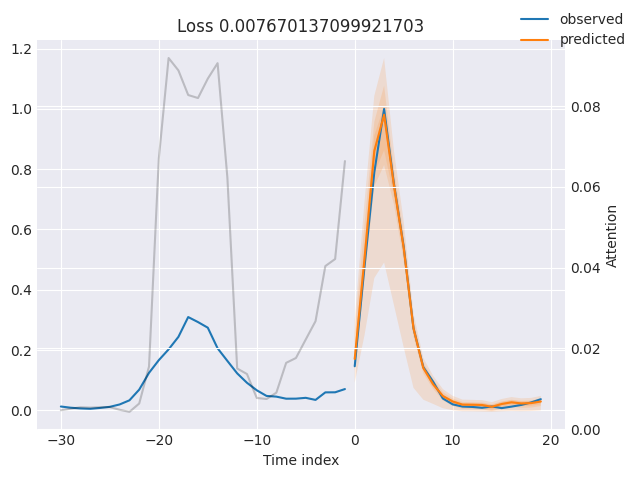

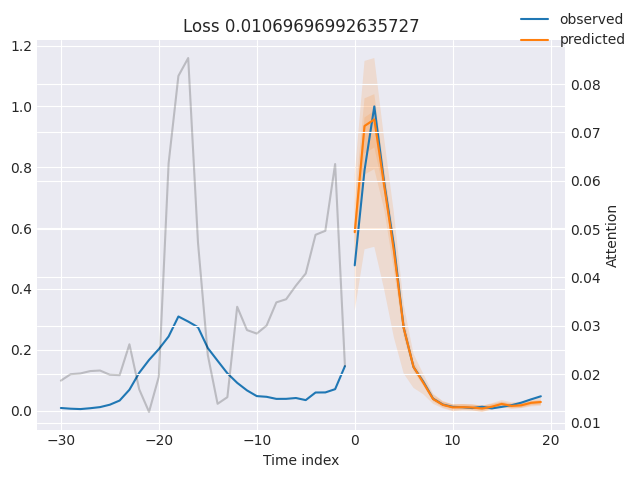

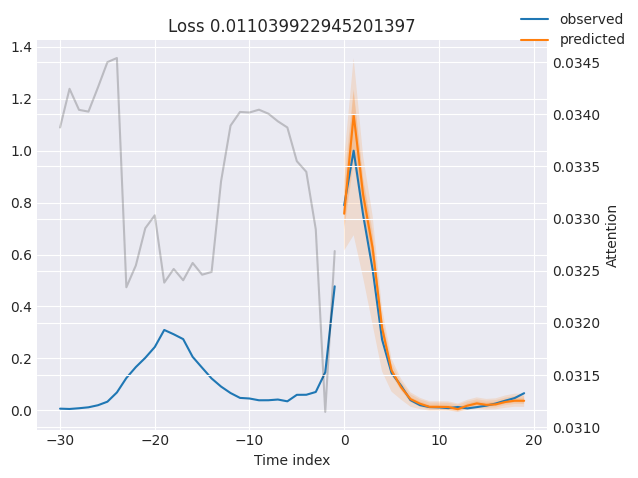

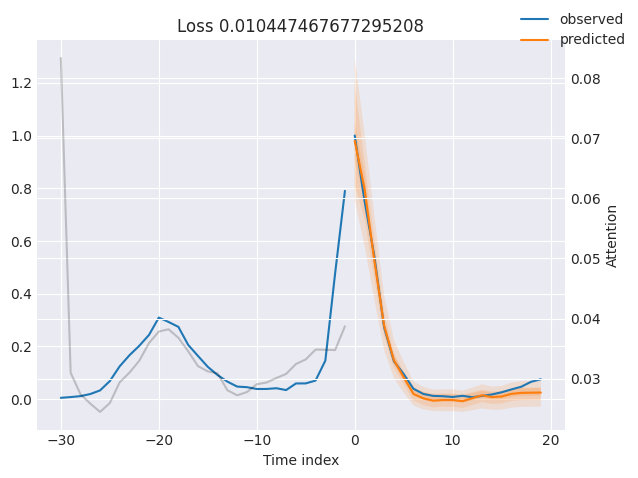

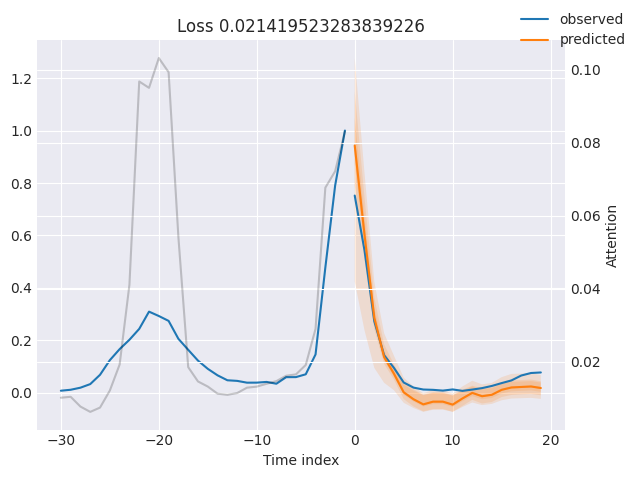

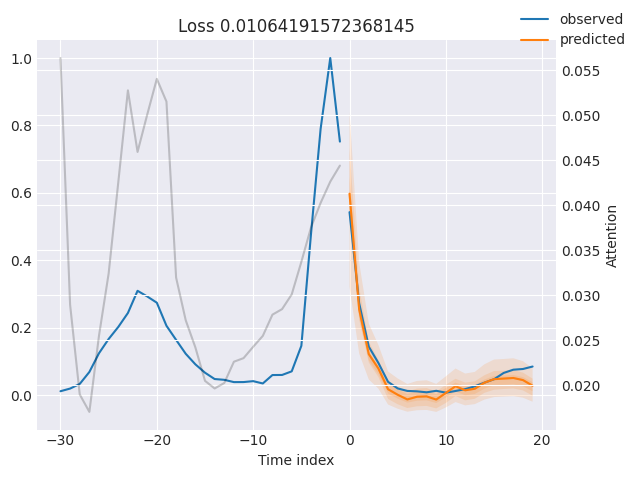

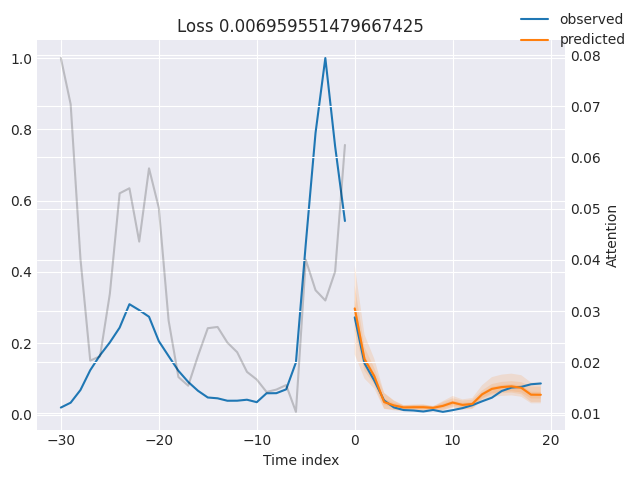

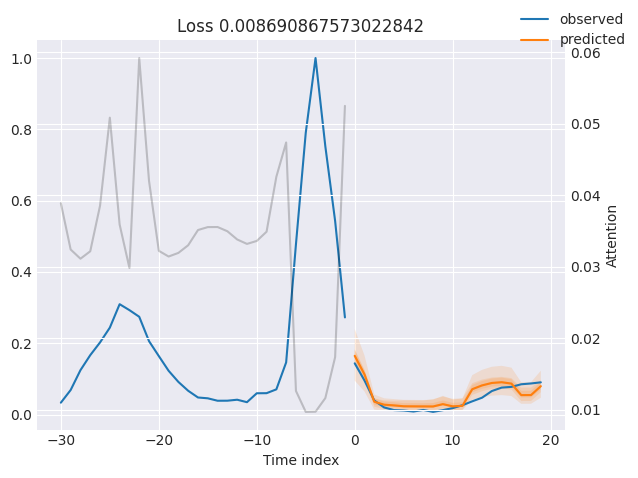

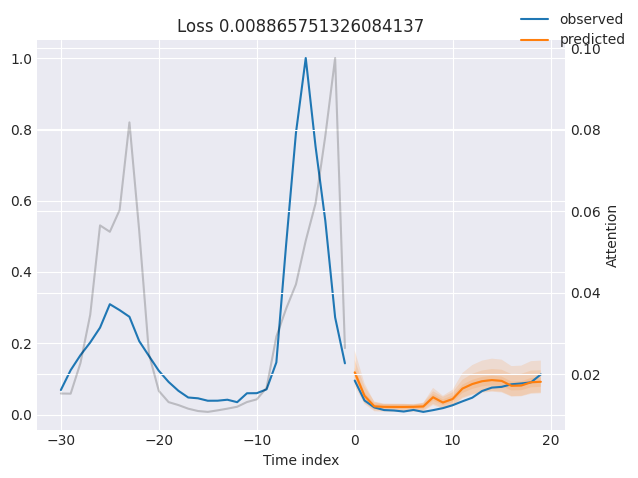

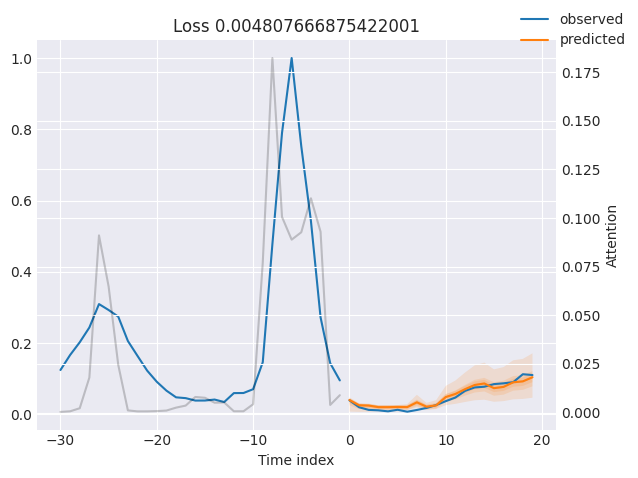

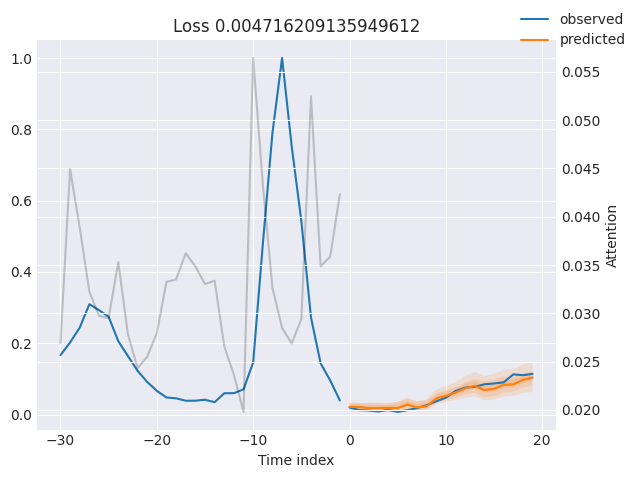

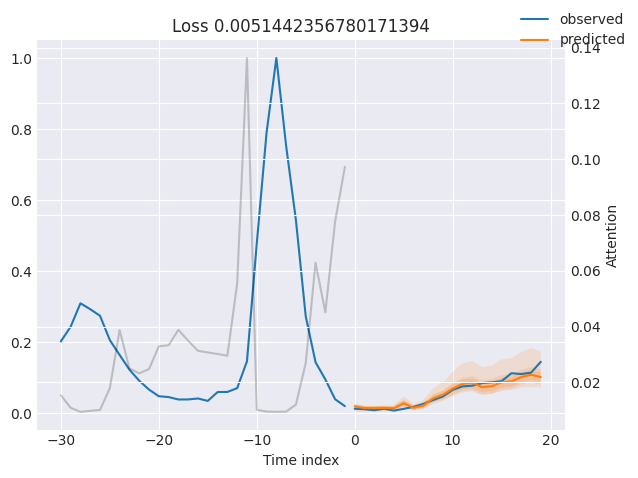

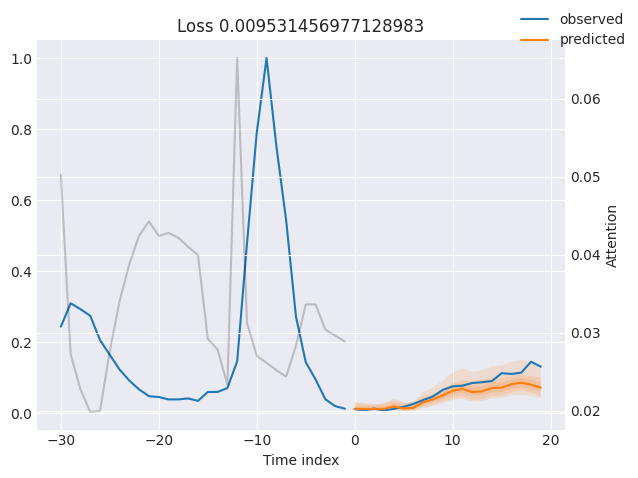

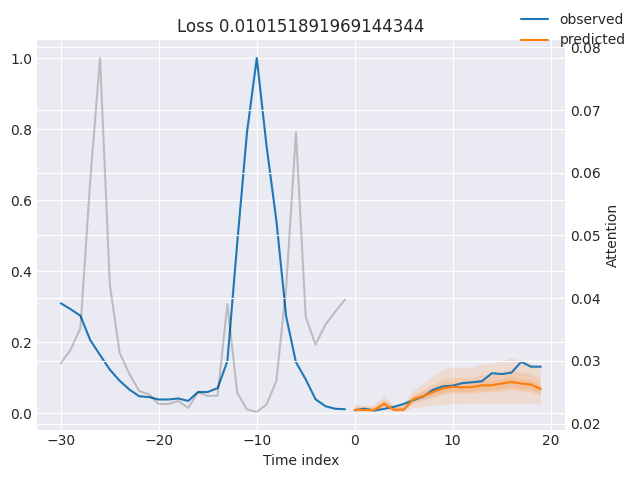

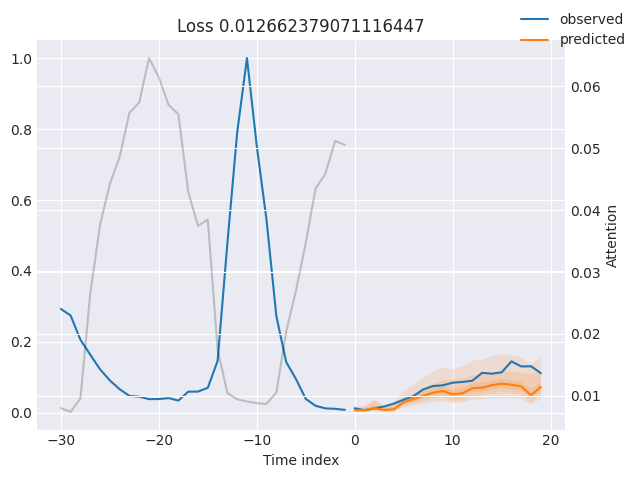

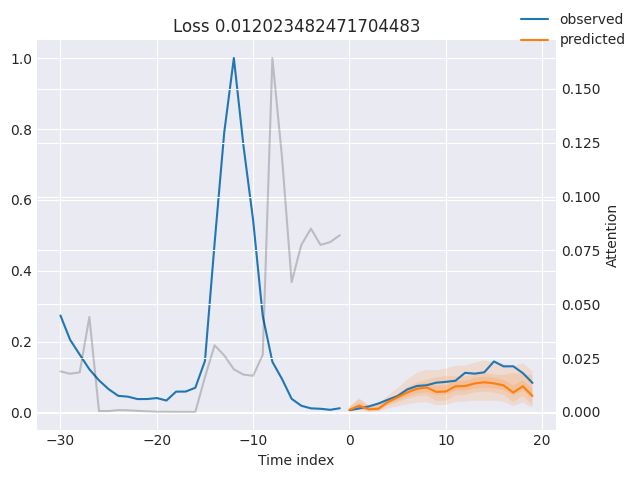

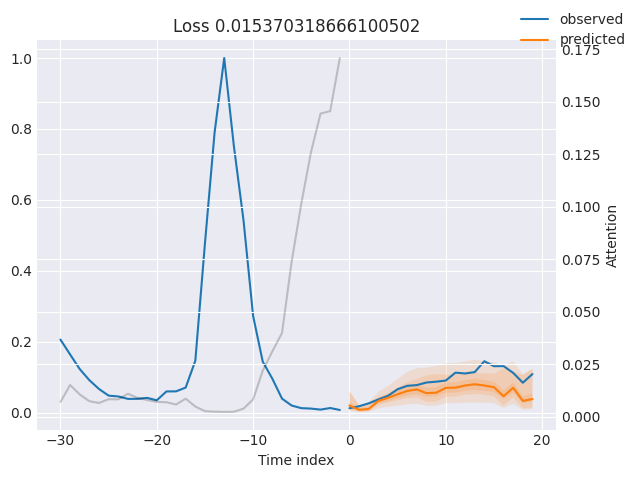

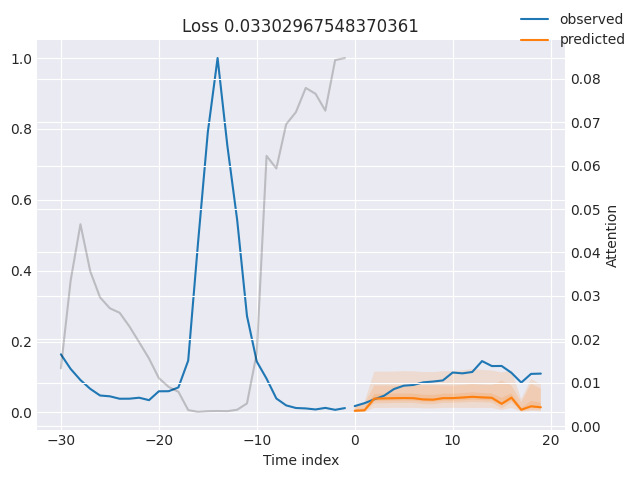

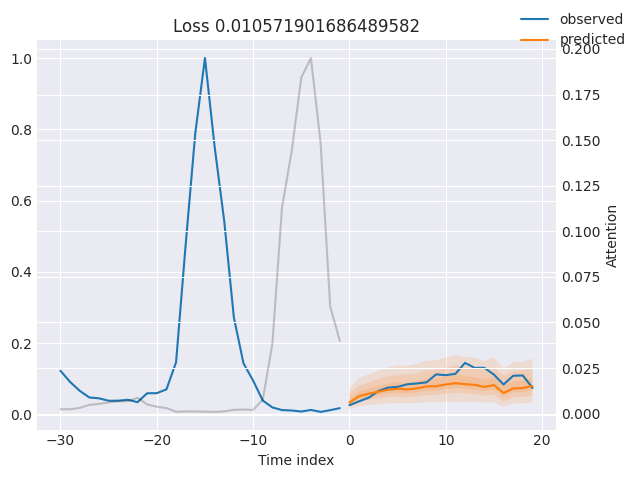

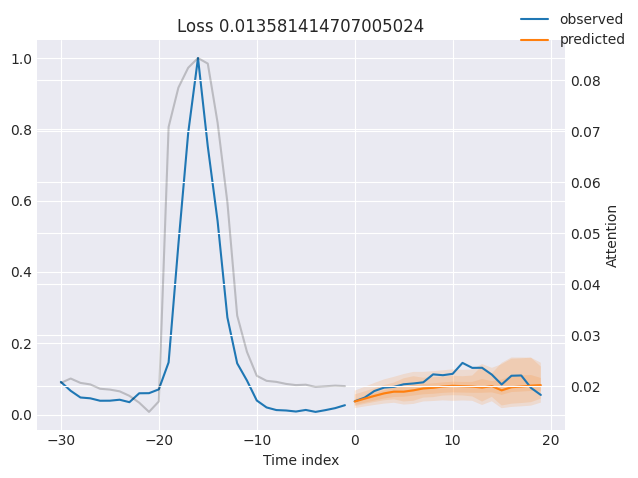

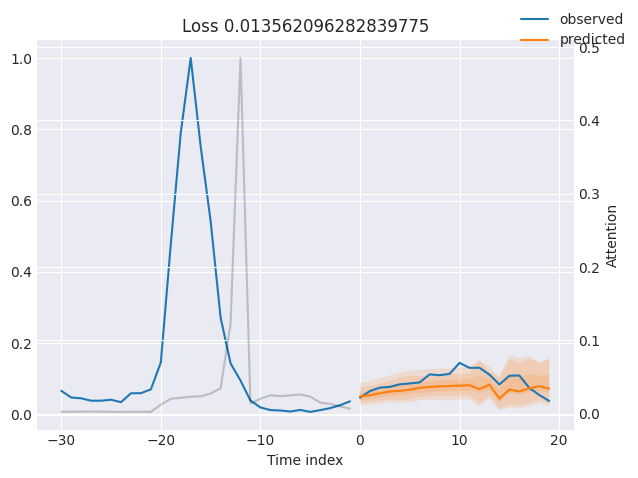

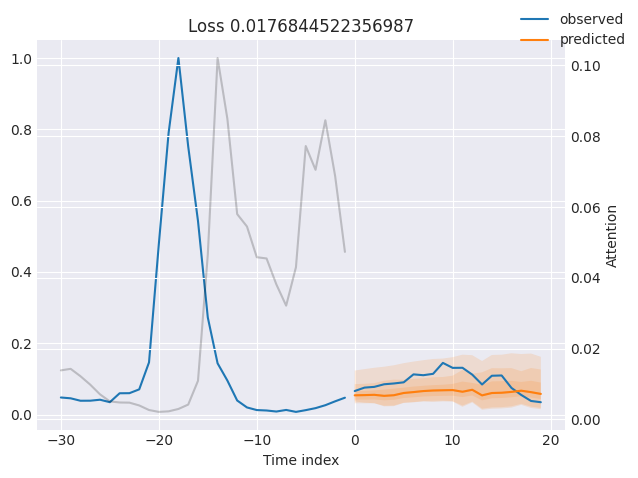

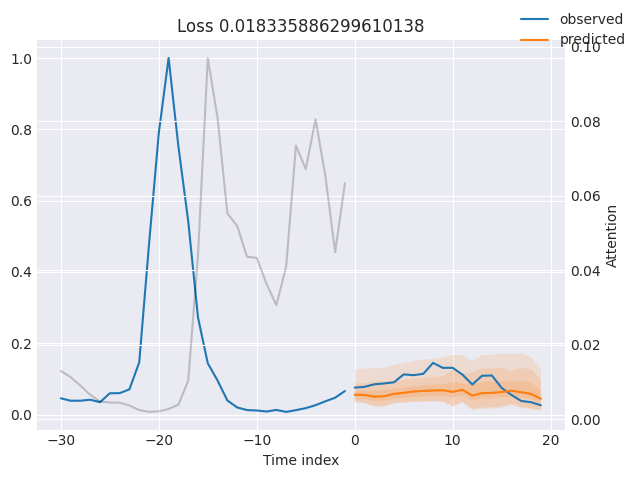

: 

In [ ]:
for n, window in enumerate(final_df_sc.rolling(window=120, closed='right')):
    #print(len(window))
    if len(window) == 120:
        train_tf_model(pd.DataFrame(window), n, "SC")
